# Library & Device

In [1]:
import os
import tqdm
import random

import torch
from torchvision import transforms, datasets
from torch.utils.data import random_split, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Wandb

In [2]:
from kaggle_secrets import UserSecretsClient
secret_label = "wandb_api_key"
secret_value = UserSecretsClient().get_secret(secret_label)

import wandb
wandb.login(key=secret_value)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hungbui0416 (project-2) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Transform

In [3]:
mean = torch.tensor([0.4914, 0.4822, 0.4465])
std = torch.tensor([0.2023, 0.1994, 0.2010])
normalize = transforms.Normalize(mean=mean, std=std)
denormalize = transforms.Normalize(mean=-mean/std, std=1/std)

cl_train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=32, scale=(0.2, 1.)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    normalize,
])

classification_train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

classification_test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize,
])

clhn_train_transform = transforms.Compose([
    denormalize,
    transforms.ToPILImage(),
    cl_train_transform
])

class MultiTransform:
    def __init__(self, transform, num_transforms):
        self.transform = transform
        self.num_transforms = num_transforms

    def __call__(self, x):
        return [self.transform(x) for _ in range(self.num_transforms)]

# Data

In [4]:
train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    transform=None,
    download=True
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    transform=None
)

val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size], generator=generator)

classes = test_dataset.classes

class TransformedDataset(Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, y = self.dataset[idx]
        return self.transform(x), y

100%|██████████| 170M/170M [00:01<00:00, 102MB/s]  


# Model

In [5]:
class CNN(nn.Module):
    def __init__(self, out_dim):
        super().__init__()
        self.out_dim = out_dim
        
        self.encoder = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.4),
        )

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, out_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        return x

# Contrastive Learning

In [6]:
cl_config = {
    "entity": "project-2",
    "project": "CIFAR10-contrastive-learning",
    "architecture": "cnn",
    "contrast_mode": "simclr",
    "num_views": 2,
    "batch_size": 1024,
    "projection_dim": 128,
    "temperature": 0.1,
    "learning_rate": 1e-3,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "num_epochs": 1000
}

In [7]:
cl_train_set = TransformedDataset(train_dataset, MultiTransform(cl_train_transform, num_transforms=cl_config['num_views']))

In [8]:
cl_train_loader = DataLoader(
    cl_train_set,
    batch_size=cl_config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [9]:
class ContrastiveLoss(nn.Module):
    def __init__(self, contrast_mode='scl', temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.contrast_mode = contrast_mode
        self.temperature = temperature
        self.base_temperature = base_temperature
        self.eps = 1e-8

    def forward(self, projs, labels):
        device = projs.device
        bsz = labels.shape[0]
        nv = projs.shape[0] // bsz
        projs = F.normalize(projs, dim=-1)

        if self.contrast_mode == 'scl':
            labels = labels.contiguous().view(-1, 1).repeat(nv, 1)
        elif self.contrast_mode == 'simclr':
            labels = torch.arange(bsz, device=device).view(-1, 1).repeat(nv, 1)

        label_mask = torch.eq(labels, labels.T).float().to(device)
        anchor_mask = ~torch.eye(bsz * nv, dtype=torch.bool, device=device)
        pos_mask = label_mask * anchor_mask

        sims = torch.matmul(projs, projs.T)
        logits = sims / self.temperature

        logit_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits_stable = logits - logit_max.detach()

        exp_logits = torch.exp(logits_stable) * anchor_mask
        log_prob = logits_stable - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)

        num_pos = pos_mask.sum(1).clamp(min=self.eps)
        mean_log_prob_pos = (pos_mask * log_prob).sum(1) / num_pos

        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.mean()
        return loss

In [10]:
def cl_batch_log(step, log_freq, loss, optimizer):
    if step % log_freq == 0:
        wandb.log({
            "train/loss": loss,
            "train/lr": optimizer.param_groups[0]['lr'],
        })


def cl_epoch_log(epoch, num_epochs, train_loss):
    print(f"epoch [{epoch:2}/{num_epochs}] train_loss {train_loss:.4f}")
    
    wandb.log({
        "train/epoch_loss": train_loss,
        "epoch": epoch
    })

In [11]:
def cl_train(epoch, loader, device, model, criterion, optimizer, scheduler, log_freq):
    model.train()
    
    total_loss = 0
    total = 0

    for step, (inputs, labels) in enumerate(tqdm.tqdm(loader, desc=f"Train epoch {epoch}")):
        inputs = torch.cat(inputs, dim=0).to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        projs = model(inputs)
        loss = criterion(projs, labels)        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

        cl_batch_log(step, log_freq, loss.item(), optimizer)

    if scheduler:
        scheduler.step()

    avg_loss = total_loss / total
    return avg_loss

In [12]:
cl_model = CNN(out_dim=cl_config['projection_dim']).to(device)
cl_model = nn.DataParallel(cl_model)
os.makedirs('./ckpt', exist_ok=True)
cl_model_dir = './ckpt/cl_model.pth'

cl_criterion = ContrastiveLoss(contrast_mode=cl_config['contrast_mode'], temperature=cl_config['temperature'])
cl_optimizer = optim.Adam(cl_model.parameters(), lr=cl_config['learning_rate'], weight_decay=cl_config['weight_decay'])
cl_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(cl_optimizer, T_max=cl_config["num_epochs"])

In [13]:
wandb.init(entity=cl_config["entity"], project=cl_config["project"], config=cl_config)

In [14]:
wandb.watch(cl_model, log="gradients", log_freq=10)

for epoch in range(1, cl_config['num_epochs'] + 1):
    train_loss = cl_train(epoch, cl_train_loader, device, cl_model, cl_criterion, cl_optimizer, cl_scheduler, log_freq=10)
    
    cl_epoch_log(epoch, cl_config['num_epochs'], train_loss)

torch.save(cl_model.state_dict(), cl_model_dir)
artifact = wandb.Artifact('model', type='model')
artifact.add_file(cl_model_dir)
wandb.log_artifact(artifact)

Train epoch 1: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [ 1/1000] train_loss 10.5609


Train epoch 2: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [ 2/1000] train_loss 9.9740


Train epoch 3: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [ 3/1000] train_loss 9.5693


Train epoch 4: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [ 4/1000] train_loss 9.3292


Train epoch 5: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [ 5/1000] train_loss 9.0396


Train epoch 6: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [ 6/1000] train_loss 8.7956


Train epoch 7: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [ 7/1000] train_loss 8.5565


Train epoch 8: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [ 8/1000] train_loss 8.3147


Train epoch 9: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [ 9/1000] train_loss 8.1290


Train epoch 10: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [10/1000] train_loss 7.9424


Train epoch 11: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [11/1000] train_loss 7.8059


Train epoch 12: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [12/1000] train_loss 7.6915


Train epoch 13: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [13/1000] train_loss 7.5911


Train epoch 14: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [14/1000] train_loss 7.4708


Train epoch 15: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [15/1000] train_loss 7.3898


Train epoch 16: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [16/1000] train_loss 7.2790


Train epoch 17: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [17/1000] train_loss 7.2228


Train epoch 18: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [18/1000] train_loss 7.1783


Train epoch 19: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [19/1000] train_loss 7.0969


Train epoch 20: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [20/1000] train_loss 7.1023


Train epoch 21: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [21/1000] train_loss 6.9867


Train epoch 22: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [22/1000] train_loss 6.9493


Train epoch 23: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [23/1000] train_loss 6.9213


Train epoch 24: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [24/1000] train_loss 6.8793


Train epoch 25: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [25/1000] train_loss 6.8226


Train epoch 26: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [26/1000] train_loss 6.8244


Train epoch 27: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [27/1000] train_loss 6.7912


Train epoch 28: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [28/1000] train_loss 6.6923


Train epoch 29: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [29/1000] train_loss 6.6665


Train epoch 30: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [30/1000] train_loss 6.6549


Train epoch 31: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [31/1000] train_loss 6.6542


Train epoch 32: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [32/1000] train_loss 6.5958


Train epoch 33: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [33/1000] train_loss 6.5742


Train epoch 34: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [34/1000] train_loss 6.5729


Train epoch 35: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [35/1000] train_loss 6.5325


Train epoch 36: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [36/1000] train_loss 6.4894


Train epoch 37: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [37/1000] train_loss 6.5118


Train epoch 38: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [38/1000] train_loss 6.4643


Train epoch 39: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [39/1000] train_loss 6.4402


Train epoch 40: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [40/1000] train_loss 6.4298


Train epoch 41: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [41/1000] train_loss 6.3972


Train epoch 42: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [42/1000] train_loss 6.3967


Train epoch 43: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [43/1000] train_loss 6.3806


Train epoch 44: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [44/1000] train_loss 6.3307


Train epoch 45: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [45/1000] train_loss 6.2949


Train epoch 46: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [46/1000] train_loss 6.3146


Train epoch 47: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [47/1000] train_loss 6.2872


Train epoch 48: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [48/1000] train_loss 6.2550


Train epoch 49: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [49/1000] train_loss 6.2553


Train epoch 50: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [50/1000] train_loss 6.2612


Train epoch 51: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [51/1000] train_loss 6.2201


Train epoch 52: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [52/1000] train_loss 6.2181


Train epoch 53: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [53/1000] train_loss 6.2321


Train epoch 54: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [54/1000] train_loss 6.1937


Train epoch 55: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [55/1000] train_loss 6.1824


Train epoch 56: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [56/1000] train_loss 6.1813


Train epoch 57: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [57/1000] train_loss 6.1262


Train epoch 58: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [58/1000] train_loss 6.1404


Train epoch 59: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [59/1000] train_loss 6.1140


Train epoch 60: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [60/1000] train_loss 6.0864


Train epoch 61: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [61/1000] train_loss 6.0814


Train epoch 62: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [62/1000] train_loss 6.0897


Train epoch 63: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [63/1000] train_loss 6.0677


Train epoch 64: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [64/1000] train_loss 6.0735


Train epoch 65: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [65/1000] train_loss 6.0202


Train epoch 66: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [66/1000] train_loss 6.0628


Train epoch 67: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [67/1000] train_loss 6.0197


Train epoch 68: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [68/1000] train_loss 6.0066


Train epoch 69: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [69/1000] train_loss 5.9978


Train epoch 70: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [70/1000] train_loss 5.9729


Train epoch 71: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [71/1000] train_loss 5.9748


Train epoch 72: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [72/1000] train_loss 5.9449


Train epoch 73: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [73/1000] train_loss 5.9323


Train epoch 74: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [74/1000] train_loss 5.9185


Train epoch 75: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [75/1000] train_loss 5.9324


Train epoch 76: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [76/1000] train_loss 5.9167


Train epoch 77: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [77/1000] train_loss 5.9061


Train epoch 78: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [78/1000] train_loss 5.9019


Train epoch 79: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [79/1000] train_loss 5.8739


Train epoch 80: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [80/1000] train_loss 5.8570


Train epoch 81: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [81/1000] train_loss 5.8697


Train epoch 82: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [82/1000] train_loss 5.8702


Train epoch 83: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [83/1000] train_loss 5.8187


Train epoch 84: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [84/1000] train_loss 5.8305


Train epoch 85: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [85/1000] train_loss 5.8081


Train epoch 86: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [86/1000] train_loss 5.7924


Train epoch 87: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [87/1000] train_loss 5.7719


Train epoch 88: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [88/1000] train_loss 5.7828


Train epoch 89: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [89/1000] train_loss 5.7767


Train epoch 90: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [90/1000] train_loss 5.7679


Train epoch 91: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [91/1000] train_loss 5.7601


Train epoch 92: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [92/1000] train_loss 5.7399


Train epoch 93: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [93/1000] train_loss 5.7568


Train epoch 94: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [94/1000] train_loss 5.7629


Train epoch 95: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [95/1000] train_loss 5.7420


Train epoch 96: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [96/1000] train_loss 5.7670


Train epoch 97: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [97/1000] train_loss 5.7130


Train epoch 98: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [98/1000] train_loss 5.7073


Train epoch 99: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [99/1000] train_loss 5.7220


Train epoch 100: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [100/1000] train_loss 5.6753


Train epoch 101: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [101/1000] train_loss 5.6887


Train epoch 102: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [102/1000] train_loss 5.6824


Train epoch 103: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [103/1000] train_loss 5.6513


Train epoch 104: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [104/1000] train_loss 5.6455


Train epoch 105: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [105/1000] train_loss 5.6383


Train epoch 106: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [106/1000] train_loss 5.6324


Train epoch 107: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [107/1000] train_loss 5.6303


Train epoch 108: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [108/1000] train_loss 5.6070


Train epoch 109: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [109/1000] train_loss 5.6135


Train epoch 110: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [110/1000] train_loss 5.6081


Train epoch 111: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [111/1000] train_loss 5.6176


Train epoch 112: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [112/1000] train_loss 5.6118


Train epoch 113: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [113/1000] train_loss 5.5912


Train epoch 114: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [114/1000] train_loss 5.5960


Train epoch 115: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [115/1000] train_loss 5.6115


Train epoch 116: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [116/1000] train_loss 5.6021


Train epoch 117: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [117/1000] train_loss 5.5796


Train epoch 118: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [118/1000] train_loss 5.5481


Train epoch 119: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [119/1000] train_loss 5.5848


Train epoch 120: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [120/1000] train_loss 5.5197


Train epoch 121: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [121/1000] train_loss 5.5368


Train epoch 122: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [122/1000] train_loss 5.5149


Train epoch 123: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [123/1000] train_loss 5.5462


Train epoch 124: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [124/1000] train_loss 5.5182


Train epoch 125: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [125/1000] train_loss 5.5053


Train epoch 126: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [126/1000] train_loss 5.4834


Train epoch 127: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [127/1000] train_loss 5.4923


Train epoch 128: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [128/1000] train_loss 5.4948


Train epoch 129: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [129/1000] train_loss 5.5186


Train epoch 130: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [130/1000] train_loss 5.4986


Train epoch 131: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [131/1000] train_loss 5.4661


Train epoch 132: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [132/1000] train_loss 5.4950


Train epoch 133: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [133/1000] train_loss 5.4647


Train epoch 134: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [134/1000] train_loss 5.4529


Train epoch 135: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [135/1000] train_loss 5.4435


Train epoch 136: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [136/1000] train_loss 5.4519


Train epoch 137: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [137/1000] train_loss 5.4526


Train epoch 138: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [138/1000] train_loss 5.4427


Train epoch 139: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [139/1000] train_loss 5.4069


Train epoch 140: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [140/1000] train_loss 5.4160


Train epoch 141: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [141/1000] train_loss 5.3934


Train epoch 142: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [142/1000] train_loss 5.4168


Train epoch 143: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [143/1000] train_loss 5.3958


Train epoch 144: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [144/1000] train_loss 5.4033


Train epoch 145: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [145/1000] train_loss 5.3897


Train epoch 146: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [146/1000] train_loss 5.4082


Train epoch 147: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [147/1000] train_loss 5.3766


Train epoch 148: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [148/1000] train_loss 5.4000


Train epoch 149: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [149/1000] train_loss 5.3764


Train epoch 150: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [150/1000] train_loss 5.3755


Train epoch 151: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [151/1000] train_loss 5.3733


Train epoch 152: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [152/1000] train_loss 5.3487


Train epoch 153: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [153/1000] train_loss 5.3464


Train epoch 154: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [154/1000] train_loss 5.3394


Train epoch 155: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [155/1000] train_loss 5.3510


Train epoch 156: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [156/1000] train_loss 5.3394


Train epoch 157: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


epoch [157/1000] train_loss 5.3670


Train epoch 158: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


epoch [158/1000] train_loss 5.3356


Train epoch 159: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [159/1000] train_loss 5.3114


Train epoch 160: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [160/1000] train_loss 5.3199


Train epoch 161: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [161/1000] train_loss 5.3288


Train epoch 162: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [162/1000] train_loss 5.3276


Train epoch 163: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [163/1000] train_loss 5.2888


Train epoch 164: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [164/1000] train_loss 5.3161


Train epoch 165: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [165/1000] train_loss 5.3013


Train epoch 166: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [166/1000] train_loss 5.3119


Train epoch 167: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [167/1000] train_loss 5.3065


Train epoch 168: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [168/1000] train_loss 5.3339


Train epoch 169: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [169/1000] train_loss 5.2961


Train epoch 170: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [170/1000] train_loss 5.3024


Train epoch 171: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [171/1000] train_loss 5.2786


Train epoch 172: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [172/1000] train_loss 5.2549


Train epoch 173: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [173/1000] train_loss 5.2777


Train epoch 174: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [174/1000] train_loss 5.2633


Train epoch 175: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [175/1000] train_loss 5.2645


Train epoch 176: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [176/1000] train_loss 5.2587


Train epoch 177: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [177/1000] train_loss 5.2688


Train epoch 178: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [178/1000] train_loss 5.2281


Train epoch 179: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [179/1000] train_loss 5.2505


Train epoch 180: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [180/1000] train_loss 5.2502


Train epoch 181: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [181/1000] train_loss 5.2514


Train epoch 182: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [182/1000] train_loss 5.2455


Train epoch 183: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [183/1000] train_loss 5.2322


Train epoch 184: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [184/1000] train_loss 5.2151


Train epoch 185: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [185/1000] train_loss 5.2256


Train epoch 186: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [186/1000] train_loss 5.2139


Train epoch 187: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [187/1000] train_loss 5.2420


Train epoch 188: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [188/1000] train_loss 5.2043


Train epoch 189: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [189/1000] train_loss 5.2364


Train epoch 190: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [190/1000] train_loss 5.2177


Train epoch 191: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [191/1000] train_loss 5.2166


Train epoch 192: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [192/1000] train_loss 5.2148


Train epoch 193: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [193/1000] train_loss 5.2126


Train epoch 194: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [194/1000] train_loss 5.2055


Train epoch 195: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [195/1000] train_loss 5.2055


Train epoch 196: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [196/1000] train_loss 5.1981


Train epoch 197: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [197/1000] train_loss 5.2000


Train epoch 198: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [198/1000] train_loss 5.1669


Train epoch 199: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [199/1000] train_loss 5.1657


Train epoch 200: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [200/1000] train_loss 5.1813


Train epoch 201: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [201/1000] train_loss 5.1731


Train epoch 202: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [202/1000] train_loss 5.1709


Train epoch 203: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [203/1000] train_loss 5.1725


Train epoch 204: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [204/1000] train_loss 5.1647


Train epoch 205: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [205/1000] train_loss 5.1746


Train epoch 206: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


epoch [206/1000] train_loss 5.1577


Train epoch 207: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [207/1000] train_loss 5.1441


Train epoch 208: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [208/1000] train_loss 5.1505


Train epoch 209: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [209/1000] train_loss 5.1565


Train epoch 210: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [210/1000] train_loss 5.1606


Train epoch 211: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [211/1000] train_loss 5.1802


Train epoch 212: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [212/1000] train_loss 5.1711


Train epoch 213: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [213/1000] train_loss 5.1536


Train epoch 214: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [214/1000] train_loss 5.1316


Train epoch 215: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [215/1000] train_loss 5.1394


Train epoch 216: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [216/1000] train_loss 5.1290


Train epoch 217: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [217/1000] train_loss 5.1289


Train epoch 218: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [218/1000] train_loss 5.1194


Train epoch 219: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [219/1000] train_loss 5.1187


Train epoch 220: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [220/1000] train_loss 5.1181


Train epoch 221: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [221/1000] train_loss 5.1066


Train epoch 222: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [222/1000] train_loss 5.1133


Train epoch 223: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [223/1000] train_loss 5.1226


Train epoch 224: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [224/1000] train_loss 5.1139


Train epoch 225: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [225/1000] train_loss 5.1066


Train epoch 226: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [226/1000] train_loss 5.1058


Train epoch 227: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [227/1000] train_loss 5.1100


Train epoch 228: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [228/1000] train_loss 5.1052


Train epoch 229: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [229/1000] train_loss 5.1233


Train epoch 230: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [230/1000] train_loss 5.0942


Train epoch 231: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [231/1000] train_loss 5.1078


Train epoch 232: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [232/1000] train_loss 5.1091


Train epoch 233: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [233/1000] train_loss 5.1039


Train epoch 234: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [234/1000] train_loss 5.0896


Train epoch 235: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [235/1000] train_loss 5.0902


Train epoch 236: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [236/1000] train_loss 5.0663


Train epoch 237: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [237/1000] train_loss 5.0899


Train epoch 238: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [238/1000] train_loss 5.0792


Train epoch 239: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [239/1000] train_loss 5.0465


Train epoch 240: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [240/1000] train_loss 5.0726


Train epoch 241: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [241/1000] train_loss 5.0699


Train epoch 242: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [242/1000] train_loss 5.0492


Train epoch 243: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [243/1000] train_loss 5.0403


Train epoch 244: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [244/1000] train_loss 5.0728


Train epoch 245: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [245/1000] train_loss 5.0665


Train epoch 246: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [246/1000] train_loss 5.0929


Train epoch 247: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [247/1000] train_loss 5.0571


Train epoch 248: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [248/1000] train_loss 5.0687


Train epoch 249: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [249/1000] train_loss 5.0561


Train epoch 250: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [250/1000] train_loss 5.0635


Train epoch 251: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [251/1000] train_loss 5.0747


Train epoch 252: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [252/1000] train_loss 5.0512


Train epoch 253: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [253/1000] train_loss 5.0659


Train epoch 254: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [254/1000] train_loss 5.0383


Train epoch 255: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [255/1000] train_loss 5.0782


Train epoch 256: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [256/1000] train_loss 5.0598


Train epoch 257: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [257/1000] train_loss 5.0556


Train epoch 258: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [258/1000] train_loss 5.0524


Train epoch 259: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [259/1000] train_loss 5.0423


Train epoch 260: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [260/1000] train_loss 5.0311


Train epoch 261: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [261/1000] train_loss 5.0424


Train epoch 262: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [262/1000] train_loss 5.0302


Train epoch 263: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [263/1000] train_loss 5.0250


Train epoch 264: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [264/1000] train_loss 5.0095


Train epoch 265: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [265/1000] train_loss 5.0150


Train epoch 266: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [266/1000] train_loss 5.0389


Train epoch 267: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [267/1000] train_loss 5.0312


Train epoch 268: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [268/1000] train_loss 5.0259


Train epoch 269: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [269/1000] train_loss 5.0249


Train epoch 270: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [270/1000] train_loss 5.0177


Train epoch 271: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [271/1000] train_loss 5.0177


Train epoch 272: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [272/1000] train_loss 4.9908


Train epoch 273: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [273/1000] train_loss 5.0156


Train epoch 274: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [274/1000] train_loss 4.9942


Train epoch 275: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


epoch [275/1000] train_loss 5.0227


Train epoch 276: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [276/1000] train_loss 5.0166


Train epoch 277: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [277/1000] train_loss 4.9998


Train epoch 278: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


epoch [278/1000] train_loss 4.9883


Train epoch 279: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [279/1000] train_loss 4.9986


Train epoch 280: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [280/1000] train_loss 5.0247


Train epoch 281: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [281/1000] train_loss 4.9992


Train epoch 282: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [282/1000] train_loss 4.9981


Train epoch 283: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [283/1000] train_loss 4.9978


Train epoch 284: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [284/1000] train_loss 4.9977


Train epoch 285: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [285/1000] train_loss 4.9978


Train epoch 286: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [286/1000] train_loss 4.9759


Train epoch 287: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [287/1000] train_loss 5.0033


Train epoch 288: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [288/1000] train_loss 4.9944


Train epoch 289: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [289/1000] train_loss 4.9573


Train epoch 290: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [290/1000] train_loss 4.9725


Train epoch 291: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [291/1000] train_loss 4.9772


Train epoch 292: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [292/1000] train_loss 4.9656


Train epoch 293: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [293/1000] train_loss 4.9663


Train epoch 294: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [294/1000] train_loss 4.9863


Train epoch 295: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [295/1000] train_loss 4.9777


Train epoch 296: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [296/1000] train_loss 4.9674


Train epoch 297: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [297/1000] train_loss 4.9659


Train epoch 298: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [298/1000] train_loss 4.9858


Train epoch 299: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [299/1000] train_loss 4.9607


Train epoch 300: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [300/1000] train_loss 4.9540


Train epoch 301: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [301/1000] train_loss 4.9744


Train epoch 302: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [302/1000] train_loss 4.9512


Train epoch 303: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [303/1000] train_loss 4.9635


Train epoch 304: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [304/1000] train_loss 4.9897


Train epoch 305: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [305/1000] train_loss 4.9620


Train epoch 306: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [306/1000] train_loss 4.9466


Train epoch 307: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [307/1000] train_loss 4.9456


Train epoch 308: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [308/1000] train_loss 4.9373


Train epoch 309: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [309/1000] train_loss 4.9587


Train epoch 310: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [310/1000] train_loss 4.9556


Train epoch 311: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [311/1000] train_loss 4.9527


Train epoch 312: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [312/1000] train_loss 4.9462


Train epoch 313: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [313/1000] train_loss 4.9342


Train epoch 314: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [314/1000] train_loss 4.9553


Train epoch 315: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [315/1000] train_loss 4.9400


Train epoch 316: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [316/1000] train_loss 4.9632


Train epoch 317: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [317/1000] train_loss 4.9338


Train epoch 318: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [318/1000] train_loss 4.9478


Train epoch 319: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [319/1000] train_loss 4.9306


Train epoch 320: 100%|██████████| 40/40 [00:34<00:00,  1.18it/s]


epoch [320/1000] train_loss 4.9302


Train epoch 321: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


epoch [321/1000] train_loss 4.9392


Train epoch 322: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [322/1000] train_loss 4.9511


Train epoch 323: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [323/1000] train_loss 4.9311


Train epoch 324: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [324/1000] train_loss 4.9213


Train epoch 325: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [325/1000] train_loss 4.9171


Train epoch 326: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [326/1000] train_loss 4.9441


Train epoch 327: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [327/1000] train_loss 4.8997


Train epoch 328: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [328/1000] train_loss 4.9256


Train epoch 329: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [329/1000] train_loss 4.9397


Train epoch 330: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [330/1000] train_loss 4.9097


Train epoch 331: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [331/1000] train_loss 4.9043


Train epoch 332: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [332/1000] train_loss 4.9157


Train epoch 333: 100%|██████████| 40/40 [00:34<00:00,  1.17it/s]


epoch [333/1000] train_loss 4.9235


Train epoch 334: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [334/1000] train_loss 4.9430


Train epoch 335: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [335/1000] train_loss 4.9137


Train epoch 336: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [336/1000] train_loss 4.9071


Train epoch 337: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [337/1000] train_loss 4.9171


Train epoch 338: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [338/1000] train_loss 4.8906


Train epoch 339: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


epoch [339/1000] train_loss 4.8989


Train epoch 340: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [340/1000] train_loss 4.8984


Train epoch 341: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [341/1000] train_loss 4.9029


Train epoch 342: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [342/1000] train_loss 4.8863


Train epoch 343: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [343/1000] train_loss 4.8851


Train epoch 344: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [344/1000] train_loss 4.8859


Train epoch 345: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [345/1000] train_loss 4.8843


Train epoch 346: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [346/1000] train_loss 4.8764


Train epoch 347: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [347/1000] train_loss 4.8798


Train epoch 348: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [348/1000] train_loss 4.8853


Train epoch 349: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [349/1000] train_loss 4.8717


Train epoch 350: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [350/1000] train_loss 4.8473


Train epoch 351: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [351/1000] train_loss 4.8958


Train epoch 352: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [352/1000] train_loss 4.8833


Train epoch 353: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [353/1000] train_loss 4.8657


Train epoch 354: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [354/1000] train_loss 4.8936


Train epoch 355: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [355/1000] train_loss 4.8801


Train epoch 356: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [356/1000] train_loss 4.8651


Train epoch 357: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [357/1000] train_loss 4.8715


Train epoch 358: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [358/1000] train_loss 4.8803


Train epoch 359: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [359/1000] train_loss 4.8575


Train epoch 360: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [360/1000] train_loss 4.8624


Train epoch 361: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [361/1000] train_loss 4.8554


Train epoch 362: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [362/1000] train_loss 4.8626


Train epoch 363: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [363/1000] train_loss 4.8457


Train epoch 364: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [364/1000] train_loss 4.8675


Train epoch 365: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [365/1000] train_loss 4.8436


Train epoch 366: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [366/1000] train_loss 4.8556


Train epoch 367: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [367/1000] train_loss 4.8406


Train epoch 368: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [368/1000] train_loss 4.8270


Train epoch 369: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [369/1000] train_loss 4.8589


Train epoch 370: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [370/1000] train_loss 4.8396


Train epoch 371: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [371/1000] train_loss 4.8752


Train epoch 372: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [372/1000] train_loss 4.8349


Train epoch 373: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [373/1000] train_loss 4.8489


Train epoch 374: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [374/1000] train_loss 4.8402


Train epoch 375: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [375/1000] train_loss 4.8664


Train epoch 376: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [376/1000] train_loss 4.8562


Train epoch 377: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [377/1000] train_loss 4.8385


Train epoch 378: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [378/1000] train_loss 4.8341


Train epoch 379: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [379/1000] train_loss 4.8243


Train epoch 380: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [380/1000] train_loss 4.8308


Train epoch 381: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [381/1000] train_loss 4.8333


Train epoch 382: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [382/1000] train_loss 4.8444


Train epoch 383: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [383/1000] train_loss 4.8309


Train epoch 384: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [384/1000] train_loss 4.8365


Train epoch 385: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [385/1000] train_loss 4.8270


Train epoch 386: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [386/1000] train_loss 4.8466


Train epoch 387: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [387/1000] train_loss 4.8356


Train epoch 388: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [388/1000] train_loss 4.8125


Train epoch 389: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [389/1000] train_loss 4.8091


Train epoch 390: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [390/1000] train_loss 4.8374


Train epoch 391: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [391/1000] train_loss 4.8272


Train epoch 392: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [392/1000] train_loss 4.8128


Train epoch 393: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [393/1000] train_loss 4.7998


Train epoch 394: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [394/1000] train_loss 4.8339


Train epoch 395: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [395/1000] train_loss 4.8178


Train epoch 396: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [396/1000] train_loss 4.8172


Train epoch 397: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [397/1000] train_loss 4.8198


Train epoch 398: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [398/1000] train_loss 4.8393


Train epoch 399: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [399/1000] train_loss 4.8180


Train epoch 400: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [400/1000] train_loss 4.8235


Train epoch 401: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [401/1000] train_loss 4.7802


Train epoch 402: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [402/1000] train_loss 4.8059


Train epoch 403: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [403/1000] train_loss 4.8081


Train epoch 404: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [404/1000] train_loss 4.8122


Train epoch 405: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [405/1000] train_loss 4.8071


Train epoch 406: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [406/1000] train_loss 4.7852


Train epoch 407: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [407/1000] train_loss 4.8054


Train epoch 408: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [408/1000] train_loss 4.7888


Train epoch 409: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [409/1000] train_loss 4.7874


Train epoch 410: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [410/1000] train_loss 4.8015


Train epoch 411: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [411/1000] train_loss 4.7928


Train epoch 412: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [412/1000] train_loss 4.7998


Train epoch 413: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [413/1000] train_loss 4.7801


Train epoch 414: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [414/1000] train_loss 4.7922


Train epoch 415: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [415/1000] train_loss 4.7609


Train epoch 416: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [416/1000] train_loss 4.7947


Train epoch 417: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [417/1000] train_loss 4.8016


Train epoch 418: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [418/1000] train_loss 4.7904


Train epoch 419: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [419/1000] train_loss 4.7919


Train epoch 420: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [420/1000] train_loss 4.7922


Train epoch 421: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [421/1000] train_loss 4.7830


Train epoch 422: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [422/1000] train_loss 4.7743


Train epoch 423: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [423/1000] train_loss 4.7915


Train epoch 424: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [424/1000] train_loss 4.7858


Train epoch 425: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [425/1000] train_loss 4.7669


Train epoch 426: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [426/1000] train_loss 4.7772


Train epoch 427: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [427/1000] train_loss 4.7720


Train epoch 428: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [428/1000] train_loss 4.7941


Train epoch 429: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [429/1000] train_loss 4.7690


Train epoch 430: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [430/1000] train_loss 4.7634


Train epoch 431: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [431/1000] train_loss 4.7617


Train epoch 432: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [432/1000] train_loss 4.7673


Train epoch 433: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [433/1000] train_loss 4.7737


Train epoch 434: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [434/1000] train_loss 4.7740


Train epoch 435: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [435/1000] train_loss 4.7505


Train epoch 436: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [436/1000] train_loss 4.7751


Train epoch 437: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [437/1000] train_loss 4.7447


Train epoch 438: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [438/1000] train_loss 4.7560


Train epoch 439: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [439/1000] train_loss 4.7516


Train epoch 440: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [440/1000] train_loss 4.7515


Train epoch 441: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [441/1000] train_loss 4.7587


Train epoch 442: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [442/1000] train_loss 4.7561


Train epoch 443: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [443/1000] train_loss 4.7770


Train epoch 444: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [444/1000] train_loss 4.7535


Train epoch 445: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [445/1000] train_loss 4.7411


Train epoch 446: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [446/1000] train_loss 4.7588


Train epoch 447: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [447/1000] train_loss 4.7608


Train epoch 448: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [448/1000] train_loss 4.7353


Train epoch 449: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [449/1000] train_loss 4.7600


Train epoch 450: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [450/1000] train_loss 4.7549


Train epoch 451: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [451/1000] train_loss 4.7598


Train epoch 452: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [452/1000] train_loss 4.7476


Train epoch 453: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [453/1000] train_loss 4.7371


Train epoch 454: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [454/1000] train_loss 4.7378


Train epoch 455: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [455/1000] train_loss 4.7461


Train epoch 456: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [456/1000] train_loss 4.7343


Train epoch 457: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [457/1000] train_loss 4.7489


Train epoch 458: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [458/1000] train_loss 4.7306


Train epoch 459: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [459/1000] train_loss 4.7193


Train epoch 460: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [460/1000] train_loss 4.7080


Train epoch 461: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [461/1000] train_loss 4.7464


Train epoch 462: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [462/1000] train_loss 4.7165


Train epoch 463: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [463/1000] train_loss 4.7459


Train epoch 464: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [464/1000] train_loss 4.7443


Train epoch 465: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [465/1000] train_loss 4.7323


Train epoch 466: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [466/1000] train_loss 4.7278


Train epoch 467: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [467/1000] train_loss 4.7397


Train epoch 468: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [468/1000] train_loss 4.7290


Train epoch 469: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [469/1000] train_loss 4.7147


Train epoch 470: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [470/1000] train_loss 4.7229


Train epoch 471: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [471/1000] train_loss 4.7124


Train epoch 472: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [472/1000] train_loss 4.7262


Train epoch 473: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [473/1000] train_loss 4.7235


Train epoch 474: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [474/1000] train_loss 4.7220


Train epoch 475: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [475/1000] train_loss 4.7132


Train epoch 476: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [476/1000] train_loss 4.7259


Train epoch 477: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [477/1000] train_loss 4.7116


Train epoch 478: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [478/1000] train_loss 4.7234


Train epoch 479: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [479/1000] train_loss 4.7004


Train epoch 480: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [480/1000] train_loss 4.7125


Train epoch 481: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [481/1000] train_loss 4.6966


Train epoch 482: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [482/1000] train_loss 4.7268


Train epoch 483: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [483/1000] train_loss 4.7050


Train epoch 484: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [484/1000] train_loss 4.7137


Train epoch 485: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [485/1000] train_loss 4.6906


Train epoch 486: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [486/1000] train_loss 4.6924


Train epoch 487: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [487/1000] train_loss 4.6793


Train epoch 488: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [488/1000] train_loss 4.6975


Train epoch 489: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [489/1000] train_loss 4.7219


Train epoch 490: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [490/1000] train_loss 4.7108


Train epoch 491: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [491/1000] train_loss 4.6956


Train epoch 492: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [492/1000] train_loss 4.6912


Train epoch 493: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [493/1000] train_loss 4.6918


Train epoch 494: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [494/1000] train_loss 4.6892


Train epoch 495: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [495/1000] train_loss 4.6906


Train epoch 496: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [496/1000] train_loss 4.6980


Train epoch 497: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [497/1000] train_loss 4.6993


Train epoch 498: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [498/1000] train_loss 4.6822


Train epoch 499: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [499/1000] train_loss 4.6721


Train epoch 500: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [500/1000] train_loss 4.6914


Train epoch 501: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [501/1000] train_loss 4.6720


Train epoch 502: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [502/1000] train_loss 4.6851


Train epoch 503: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [503/1000] train_loss 4.6874


Train epoch 504: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [504/1000] train_loss 4.6783


Train epoch 505: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [505/1000] train_loss 4.6850


Train epoch 506: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [506/1000] train_loss 4.6762


Train epoch 507: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [507/1000] train_loss 4.6934


Train epoch 508: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [508/1000] train_loss 4.6717


Train epoch 509: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [509/1000] train_loss 4.6680


Train epoch 510: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [510/1000] train_loss 4.6929


Train epoch 511: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [511/1000] train_loss 4.6797


Train epoch 512: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [512/1000] train_loss 4.6667


Train epoch 513: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [513/1000] train_loss 4.6510


Train epoch 514: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [514/1000] train_loss 4.6714


Train epoch 515: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [515/1000] train_loss 4.6594


Train epoch 516: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [516/1000] train_loss 4.6774


Train epoch 517: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [517/1000] train_loss 4.6880


Train epoch 518: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [518/1000] train_loss 4.6614


Train epoch 519: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [519/1000] train_loss 4.6674


Train epoch 520: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [520/1000] train_loss 4.6565


Train epoch 521: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [521/1000] train_loss 4.6770


Train epoch 522: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [522/1000] train_loss 4.6707


Train epoch 523: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [523/1000] train_loss 4.6510


Train epoch 524: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [524/1000] train_loss 4.6609


Train epoch 525: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [525/1000] train_loss 4.6638


Train epoch 526: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [526/1000] train_loss 4.6708


Train epoch 527: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [527/1000] train_loss 4.6706


Train epoch 528: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [528/1000] train_loss 4.6658


Train epoch 529: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [529/1000] train_loss 4.6264


Train epoch 530: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [530/1000] train_loss 4.6490


Train epoch 531: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [531/1000] train_loss 4.6360


Train epoch 532: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [532/1000] train_loss 4.6473


Train epoch 533: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [533/1000] train_loss 4.6215


Train epoch 534: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [534/1000] train_loss 4.6494


Train epoch 535: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [535/1000] train_loss 4.6302


Train epoch 536: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [536/1000] train_loss 4.6409


Train epoch 537: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [537/1000] train_loss 4.6421


Train epoch 538: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [538/1000] train_loss 4.6554


Train epoch 539: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [539/1000] train_loss 4.6555


Train epoch 540: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [540/1000] train_loss 4.6259


Train epoch 541: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [541/1000] train_loss 4.6510


Train epoch 542: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [542/1000] train_loss 4.6362


Train epoch 543: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [543/1000] train_loss 4.6381


Train epoch 544: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [544/1000] train_loss 4.6332


Train epoch 545: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [545/1000] train_loss 4.6206


Train epoch 546: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [546/1000] train_loss 4.6214


Train epoch 547: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [547/1000] train_loss 4.6282


Train epoch 548: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [548/1000] train_loss 4.6444


Train epoch 549: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [549/1000] train_loss 4.6230


Train epoch 550: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [550/1000] train_loss 4.6254


Train epoch 551: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [551/1000] train_loss 4.6446


Train epoch 552: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [552/1000] train_loss 4.6375


Train epoch 553: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [553/1000] train_loss 4.6126


Train epoch 554: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [554/1000] train_loss 4.6100


Train epoch 555: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [555/1000] train_loss 4.6082


Train epoch 556: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [556/1000] train_loss 4.5985


Train epoch 557: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [557/1000] train_loss 4.6103


Train epoch 558: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [558/1000] train_loss 4.6145


Train epoch 559: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [559/1000] train_loss 4.6293


Train epoch 560: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [560/1000] train_loss 4.6196


Train epoch 561: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [561/1000] train_loss 4.6091


Train epoch 562: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [562/1000] train_loss 4.6263


Train epoch 563: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [563/1000] train_loss 4.6176


Train epoch 564: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [564/1000] train_loss 4.6001


Train epoch 565: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [565/1000] train_loss 4.6147


Train epoch 566: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [566/1000] train_loss 4.5992


Train epoch 567: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [567/1000] train_loss 4.6059


Train epoch 568: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [568/1000] train_loss 4.6056


Train epoch 569: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [569/1000] train_loss 4.6111


Train epoch 570: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [570/1000] train_loss 4.6114


Train epoch 571: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [571/1000] train_loss 4.6081


Train epoch 572: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [572/1000] train_loss 4.5996


Train epoch 573: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [573/1000] train_loss 4.6067


Train epoch 574: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [574/1000] train_loss 4.5894


Train epoch 575: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [575/1000] train_loss 4.5943


Train epoch 576: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [576/1000] train_loss 4.6078


Train epoch 577: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [577/1000] train_loss 4.5951


Train epoch 578: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [578/1000] train_loss 4.5978


Train epoch 579: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [579/1000] train_loss 4.5808


Train epoch 580: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [580/1000] train_loss 4.6053


Train epoch 581: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [581/1000] train_loss 4.5856


Train epoch 582: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [582/1000] train_loss 4.6219


Train epoch 583: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [583/1000] train_loss 4.5830


Train epoch 584: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [584/1000] train_loss 4.6079


Train epoch 585: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [585/1000] train_loss 4.6082


Train epoch 586: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [586/1000] train_loss 4.6186


Train epoch 587: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [587/1000] train_loss 4.5793


Train epoch 588: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [588/1000] train_loss 4.5861


Train epoch 589: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [589/1000] train_loss 4.5951


Train epoch 590: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [590/1000] train_loss 4.5787


Train epoch 591: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [591/1000] train_loss 4.5983


Train epoch 592: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [592/1000] train_loss 4.5947


Train epoch 593: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [593/1000] train_loss 4.5845


Train epoch 594: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [594/1000] train_loss 4.5725


Train epoch 595: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [595/1000] train_loss 4.5688


Train epoch 596: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [596/1000] train_loss 4.5708


Train epoch 597: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [597/1000] train_loss 4.5676


Train epoch 598: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [598/1000] train_loss 4.5754


Train epoch 599: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [599/1000] train_loss 4.5787


Train epoch 600: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [600/1000] train_loss 4.5865


Train epoch 601: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [601/1000] train_loss 4.5697


Train epoch 602: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [602/1000] train_loss 4.5847


Train epoch 603: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [603/1000] train_loss 4.5660


Train epoch 604: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [604/1000] train_loss 4.5410


Train epoch 605: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [605/1000] train_loss 4.5698


Train epoch 606: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [606/1000] train_loss 4.5718


Train epoch 607: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [607/1000] train_loss 4.5817


Train epoch 608: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [608/1000] train_loss 4.5738


Train epoch 609: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [609/1000] train_loss 4.5432


Train epoch 610: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [610/1000] train_loss 4.5609


Train epoch 611: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [611/1000] train_loss 4.5834


Train epoch 612: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [612/1000] train_loss 4.5706


Train epoch 613: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [613/1000] train_loss 4.5682


Train epoch 614: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [614/1000] train_loss 4.5377


Train epoch 615: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [615/1000] train_loss 4.5556


Train epoch 616: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [616/1000] train_loss 4.5601


Train epoch 617: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [617/1000] train_loss 4.5600


Train epoch 618: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [618/1000] train_loss 4.5579


Train epoch 619: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [619/1000] train_loss 4.5464


Train epoch 620: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [620/1000] train_loss 4.5693


Train epoch 621: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [621/1000] train_loss 4.5320


Train epoch 622: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [622/1000] train_loss 4.5542


Train epoch 623: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [623/1000] train_loss 4.5404


Train epoch 624: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [624/1000] train_loss 4.5451


Train epoch 625: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [625/1000] train_loss 4.5366


Train epoch 626: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [626/1000] train_loss 4.5474


Train epoch 627: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [627/1000] train_loss 4.5368


Train epoch 628: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [628/1000] train_loss 4.5452


Train epoch 629: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [629/1000] train_loss 4.5312


Train epoch 630: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [630/1000] train_loss 4.5495


Train epoch 631: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [631/1000] train_loss 4.5418


Train epoch 632: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [632/1000] train_loss 4.5308


Train epoch 633: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [633/1000] train_loss 4.5390


Train epoch 634: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [634/1000] train_loss 4.5608


Train epoch 635: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [635/1000] train_loss 4.5421


Train epoch 636: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [636/1000] train_loss 4.5353


Train epoch 637: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [637/1000] train_loss 4.5520


Train epoch 638: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [638/1000] train_loss 4.5338


Train epoch 639: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [639/1000] train_loss 4.5356


Train epoch 640: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [640/1000] train_loss 4.5248


Train epoch 641: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [641/1000] train_loss 4.5184


Train epoch 642: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [642/1000] train_loss 4.5317


Train epoch 643: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [643/1000] train_loss 4.5337


Train epoch 644: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [644/1000] train_loss 4.5163


Train epoch 645: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [645/1000] train_loss 4.5092


Train epoch 646: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [646/1000] train_loss 4.5245


Train epoch 647: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [647/1000] train_loss 4.5191


Train epoch 648: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [648/1000] train_loss 4.5156


Train epoch 649: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [649/1000] train_loss 4.5228


Train epoch 650: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [650/1000] train_loss 4.5092


Train epoch 651: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [651/1000] train_loss 4.5173


Train epoch 652: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [652/1000] train_loss 4.5094


Train epoch 653: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [653/1000] train_loss 4.5290


Train epoch 654: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [654/1000] train_loss 4.5081


Train epoch 655: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [655/1000] train_loss 4.5135


Train epoch 656: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [656/1000] train_loss 4.5222


Train epoch 657: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [657/1000] train_loss 4.5292


Train epoch 658: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [658/1000] train_loss 4.5424


Train epoch 659: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [659/1000] train_loss 4.5057


Train epoch 660: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [660/1000] train_loss 4.5063


Train epoch 661: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [661/1000] train_loss 4.5112


Train epoch 662: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [662/1000] train_loss 4.5233


Train epoch 663: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [663/1000] train_loss 4.5229


Train epoch 664: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [664/1000] train_loss 4.5117


Train epoch 665: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [665/1000] train_loss 4.5065


Train epoch 666: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [666/1000] train_loss 4.5096


Train epoch 667: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [667/1000] train_loss 4.4887


Train epoch 668: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [668/1000] train_loss 4.5044


Train epoch 669: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [669/1000] train_loss 4.4897


Train epoch 670: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [670/1000] train_loss 4.5117


Train epoch 671: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [671/1000] train_loss 4.5192


Train epoch 672: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [672/1000] train_loss 4.4991


Train epoch 673: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [673/1000] train_loss 4.4954


Train epoch 674: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [674/1000] train_loss 4.5226


Train epoch 675: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [675/1000] train_loss 4.5079


Train epoch 676: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [676/1000] train_loss 4.4850


Train epoch 677: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [677/1000] train_loss 4.5146


Train epoch 678: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [678/1000] train_loss 4.4890


Train epoch 679: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [679/1000] train_loss 4.4954


Train epoch 680: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [680/1000] train_loss 4.4840


Train epoch 681: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [681/1000] train_loss 4.4900


Train epoch 682: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [682/1000] train_loss 4.4966


Train epoch 683: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [683/1000] train_loss 4.4713


Train epoch 684: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [684/1000] train_loss 4.5014


Train epoch 685: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [685/1000] train_loss 4.4996


Train epoch 686: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [686/1000] train_loss 4.4880


Train epoch 687: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [687/1000] train_loss 4.4957


Train epoch 688: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [688/1000] train_loss 4.4838


Train epoch 689: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [689/1000] train_loss 4.4889


Train epoch 690: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [690/1000] train_loss 4.4909


Train epoch 691: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [691/1000] train_loss 4.4878


Train epoch 692: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [692/1000] train_loss 4.4926


Train epoch 693: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [693/1000] train_loss 4.4953


Train epoch 694: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [694/1000] train_loss 4.4866


Train epoch 695: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [695/1000] train_loss 4.4783


Train epoch 696: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [696/1000] train_loss 4.4627


Train epoch 697: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [697/1000] train_loss 4.4518


Train epoch 698: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [698/1000] train_loss 4.4719


Train epoch 699: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [699/1000] train_loss 4.4768


Train epoch 700: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [700/1000] train_loss 4.4810


Train epoch 701: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [701/1000] train_loss 4.4896


Train epoch 702: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [702/1000] train_loss 4.4799


Train epoch 703: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [703/1000] train_loss 4.4766


Train epoch 704: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [704/1000] train_loss 4.4548


Train epoch 705: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [705/1000] train_loss 4.4730


Train epoch 706: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [706/1000] train_loss 4.4682


Train epoch 707: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [707/1000] train_loss 4.4708


Train epoch 708: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [708/1000] train_loss 4.4742


Train epoch 709: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [709/1000] train_loss 4.4650


Train epoch 710: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [710/1000] train_loss 4.4650


Train epoch 711: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [711/1000] train_loss 4.4451


Train epoch 712: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [712/1000] train_loss 4.4585


Train epoch 713: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [713/1000] train_loss 4.4871


Train epoch 714: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [714/1000] train_loss 4.4481


Train epoch 715: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [715/1000] train_loss 4.4683


Train epoch 716: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [716/1000] train_loss 4.4622


Train epoch 717: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [717/1000] train_loss 4.4406


Train epoch 718: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [718/1000] train_loss 4.4576


Train epoch 719: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [719/1000] train_loss 4.4599


Train epoch 720: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [720/1000] train_loss 4.4597


Train epoch 721: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [721/1000] train_loss 4.4382


Train epoch 722: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [722/1000] train_loss 4.4626


Train epoch 723: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [723/1000] train_loss 4.4528


Train epoch 724: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [724/1000] train_loss 4.4515


Train epoch 725: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [725/1000] train_loss 4.4701


Train epoch 726: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [726/1000] train_loss 4.4510


Train epoch 727: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [727/1000] train_loss 4.4529


Train epoch 728: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [728/1000] train_loss 4.4487


Train epoch 729: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [729/1000] train_loss 4.4459


Train epoch 730: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [730/1000] train_loss 4.4409


Train epoch 731: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [731/1000] train_loss 4.4507


Train epoch 732: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [732/1000] train_loss 4.4446


Train epoch 733: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [733/1000] train_loss 4.4558


Train epoch 734: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [734/1000] train_loss 4.4410


Train epoch 735: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [735/1000] train_loss 4.4396


Train epoch 736: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [736/1000] train_loss 4.4448


Train epoch 737: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [737/1000] train_loss 4.4407


Train epoch 738: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [738/1000] train_loss 4.4507


Train epoch 739: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [739/1000] train_loss 4.4355


Train epoch 740: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [740/1000] train_loss 4.4179


Train epoch 741: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [741/1000] train_loss 4.4483


Train epoch 742: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [742/1000] train_loss 4.4405


Train epoch 743: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [743/1000] train_loss 4.4492


Train epoch 744: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [744/1000] train_loss 4.4321


Train epoch 745: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [745/1000] train_loss 4.4418


Train epoch 746: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [746/1000] train_loss 4.4256


Train epoch 747: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [747/1000] train_loss 4.4188


Train epoch 748: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [748/1000] train_loss 4.4307


Train epoch 749: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [749/1000] train_loss 4.4511


Train epoch 750: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [750/1000] train_loss 4.4359


Train epoch 751: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [751/1000] train_loss 4.4280


Train epoch 752: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [752/1000] train_loss 4.4380


Train epoch 753: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [753/1000] train_loss 4.4191


Train epoch 754: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [754/1000] train_loss 4.4245


Train epoch 755: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [755/1000] train_loss 4.4311


Train epoch 756: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [756/1000] train_loss 4.4209


Train epoch 757: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [757/1000] train_loss 4.4275


Train epoch 758: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [758/1000] train_loss 4.4348


Train epoch 759: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [759/1000] train_loss 4.4139


Train epoch 760: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [760/1000] train_loss 4.4294


Train epoch 761: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [761/1000] train_loss 4.4306


Train epoch 762: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [762/1000] train_loss 4.4133


Train epoch 763: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [763/1000] train_loss 4.4369


Train epoch 764: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [764/1000] train_loss 4.4380


Train epoch 765: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [765/1000] train_loss 4.4153


Train epoch 766: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [766/1000] train_loss 4.4151


Train epoch 767: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [767/1000] train_loss 4.4286


Train epoch 768: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [768/1000] train_loss 4.4289


Train epoch 769: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [769/1000] train_loss 4.4003


Train epoch 770: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [770/1000] train_loss 4.4198


Train epoch 771: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [771/1000] train_loss 4.4265


Train epoch 772: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [772/1000] train_loss 4.3952


Train epoch 773: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [773/1000] train_loss 4.4107


Train epoch 774: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [774/1000] train_loss 4.4106


Train epoch 775: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [775/1000] train_loss 4.4057


Train epoch 776: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [776/1000] train_loss 4.3875


Train epoch 777: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [777/1000] train_loss 4.3909


Train epoch 778: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [778/1000] train_loss 4.4109


Train epoch 779: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [779/1000] train_loss 4.4174


Train epoch 780: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [780/1000] train_loss 4.4140


Train epoch 781: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [781/1000] train_loss 4.3959


Train epoch 782: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [782/1000] train_loss 4.3981


Train epoch 783: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [783/1000] train_loss 4.4223


Train epoch 784: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [784/1000] train_loss 4.3954


Train epoch 785: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [785/1000] train_loss 4.4077


Train epoch 786: 100%|██████████| 40/40 [00:33<00:00,  1.18it/s]


epoch [786/1000] train_loss 4.3983


Train epoch 787: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [787/1000] train_loss 4.3937


Train epoch 788: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [788/1000] train_loss 4.4013


Train epoch 789: 100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


epoch [789/1000] train_loss 4.4152


Train epoch 790: 100%|██████████| 40/40 [00:34<00:00,  1.18it/s]


epoch [790/1000] train_loss 4.3928


Train epoch 791: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [791/1000] train_loss 4.4049


Train epoch 792: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [792/1000] train_loss 4.3990


Train epoch 793: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [793/1000] train_loss 4.4102


Train epoch 794: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [794/1000] train_loss 4.3891


Train epoch 795: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [795/1000] train_loss 4.4015


Train epoch 796: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [796/1000] train_loss 4.3999


Train epoch 797: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [797/1000] train_loss 4.4028


Train epoch 798: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [798/1000] train_loss 4.3924


Train epoch 799: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [799/1000] train_loss 4.3909


Train epoch 800: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [800/1000] train_loss 4.3956


Train epoch 801: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [801/1000] train_loss 4.3829


Train epoch 802: 100%|██████████| 40/40 [00:31<00:00,  1.26it/s]


epoch [802/1000] train_loss 4.3926


Train epoch 803: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [803/1000] train_loss 4.3944


Train epoch 804: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [804/1000] train_loss 4.3979


Train epoch 805: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [805/1000] train_loss 4.3893


Train epoch 806: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [806/1000] train_loss 4.3793


Train epoch 807: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [807/1000] train_loss 4.3894


Train epoch 808: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [808/1000] train_loss 4.3756


Train epoch 809: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [809/1000] train_loss 4.3842


Train epoch 810: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [810/1000] train_loss 4.3944


Train epoch 811: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [811/1000] train_loss 4.3802


Train epoch 812: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [812/1000] train_loss 4.3929


Train epoch 813: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [813/1000] train_loss 4.3683


Train epoch 814: 100%|██████████| 40/40 [00:31<00:00,  1.25it/s]


epoch [814/1000] train_loss 4.3921


Train epoch 815: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [815/1000] train_loss 4.3772


Train epoch 816: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [816/1000] train_loss 4.3861


Train epoch 817: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [817/1000] train_loss 4.3768


Train epoch 818: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [818/1000] train_loss 4.3934


Train epoch 819: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [819/1000] train_loss 4.3977


Train epoch 820: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [820/1000] train_loss 4.3747


Train epoch 821: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [821/1000] train_loss 4.3871


Train epoch 822: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [822/1000] train_loss 4.3864


Train epoch 823: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [823/1000] train_loss 4.3923


Train epoch 824: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [824/1000] train_loss 4.3808


Train epoch 825: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [825/1000] train_loss 4.3807


Train epoch 826: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [826/1000] train_loss 4.3940


Train epoch 827: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [827/1000] train_loss 4.3757


Train epoch 828: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [828/1000] train_loss 4.3814


Train epoch 829: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [829/1000] train_loss 4.3839


Train epoch 830: 100%|██████████| 40/40 [00:33<00:00,  1.19it/s]


epoch [830/1000] train_loss 4.3755


Train epoch 831: 100%|██████████| 40/40 [00:33<00:00,  1.21it/s]


epoch [831/1000] train_loss 4.3726


Train epoch 832: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [832/1000] train_loss 4.3772


Train epoch 833: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [833/1000] train_loss 4.3823


Train epoch 834: 100%|██████████| 40/40 [00:32<00:00,  1.21it/s]


epoch [834/1000] train_loss 4.3741


Train epoch 835: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [835/1000] train_loss 4.3692


Train epoch 836: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [836/1000] train_loss 4.3961


Train epoch 837: 100%|██████████| 40/40 [00:33<00:00,  1.20it/s]


epoch [837/1000] train_loss 4.3782


Train epoch 838: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [838/1000] train_loss 4.3751


Train epoch 839: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [839/1000] train_loss 4.3865


Train epoch 840: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [840/1000] train_loss 4.3759


Train epoch 841: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [841/1000] train_loss 4.3587


Train epoch 842: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [842/1000] train_loss 4.3874


Train epoch 843: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [843/1000] train_loss 4.3470


Train epoch 844: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [844/1000] train_loss 4.3742


Train epoch 845: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [845/1000] train_loss 4.3764


Train epoch 846: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [846/1000] train_loss 4.3933


Train epoch 847: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [847/1000] train_loss 4.3627


Train epoch 848: 100%|██████████| 40/40 [00:32<00:00,  1.23it/s]


epoch [848/1000] train_loss 4.3811


Train epoch 849: 100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


epoch [849/1000] train_loss 4.3757


Train epoch 850: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [850/1000] train_loss 4.3709


Train epoch 851: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [851/1000] train_loss 4.3672


Train epoch 852: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [852/1000] train_loss 4.3751


Train epoch 853: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [853/1000] train_loss 4.3773


Train epoch 854: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [854/1000] train_loss 4.3710


Train epoch 855: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [855/1000] train_loss 4.3773


Train epoch 856: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [856/1000] train_loss 4.3665


Train epoch 857: 100%|██████████| 40/40 [00:32<00:00,  1.24it/s]


epoch [857/1000] train_loss 4.3556


Train epoch 858: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [858/1000] train_loss 4.3677


Train epoch 859: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [859/1000] train_loss 4.3607


Train epoch 860: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [860/1000] train_loss 4.3507


Train epoch 861: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [861/1000] train_loss 4.3608


Train epoch 862: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [862/1000] train_loss 4.3646


Train epoch 863: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [863/1000] train_loss 4.3710


Train epoch 864: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [864/1000] train_loss 4.3650


Train epoch 865: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [865/1000] train_loss 4.3437


Train epoch 866: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [866/1000] train_loss 4.3597


Train epoch 867: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [867/1000] train_loss 4.3632


Train epoch 868: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [868/1000] train_loss 4.3523


Train epoch 869: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [869/1000] train_loss 4.3604


Train epoch 870: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [870/1000] train_loss 4.3865


Train epoch 871: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [871/1000] train_loss 4.3643


Train epoch 872: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [872/1000] train_loss 4.3659


Train epoch 873: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [873/1000] train_loss 4.3423


Train epoch 874: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [874/1000] train_loss 4.3671


Train epoch 875: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [875/1000] train_loss 4.3782


Train epoch 876: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [876/1000] train_loss 4.3493


Train epoch 877: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [877/1000] train_loss 4.3529


Train epoch 878: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [878/1000] train_loss 4.3728


Train epoch 879: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [879/1000] train_loss 4.3699


Train epoch 880: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [880/1000] train_loss 4.3615


Train epoch 881: 100%|██████████| 40/40 [00:28<00:00,  1.39it/s]


epoch [881/1000] train_loss 4.3597


Train epoch 882: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [882/1000] train_loss 4.3506


Train epoch 883: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [883/1000] train_loss 4.3496


Train epoch 884: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [884/1000] train_loss 4.3447


Train epoch 885: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [885/1000] train_loss 4.3584


Train epoch 886: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [886/1000] train_loss 4.3554


Train epoch 887: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [887/1000] train_loss 4.3562


Train epoch 888: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [888/1000] train_loss 4.3447


Train epoch 889: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [889/1000] train_loss 4.3562


Train epoch 890: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [890/1000] train_loss 4.3445


Train epoch 891: 100%|██████████| 40/40 [00:28<00:00,  1.40it/s]


epoch [891/1000] train_loss 4.3320


Train epoch 892: 100%|██████████| 40/40 [00:29<00:00,  1.38it/s]


epoch [892/1000] train_loss 4.3382


Train epoch 893: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [893/1000] train_loss 4.3550


Train epoch 894: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [894/1000] train_loss 4.3424


Train epoch 895: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [895/1000] train_loss 4.3462


Train epoch 896: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [896/1000] train_loss 4.3374


Train epoch 897: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [897/1000] train_loss 4.3542


Train epoch 898: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [898/1000] train_loss 4.3554


Train epoch 899: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [899/1000] train_loss 4.3519


Train epoch 900: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [900/1000] train_loss 4.3654


Train epoch 901: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [901/1000] train_loss 4.3353


Train epoch 902: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [902/1000] train_loss 4.3428


Train epoch 903: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [903/1000] train_loss 4.3435


Train epoch 904: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [904/1000] train_loss 4.3543


Train epoch 905: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [905/1000] train_loss 4.3416


Train epoch 906: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [906/1000] train_loss 4.3410


Train epoch 907: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [907/1000] train_loss 4.3538


Train epoch 908: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [908/1000] train_loss 4.3357


Train epoch 909: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [909/1000] train_loss 4.3390


Train epoch 910: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [910/1000] train_loss 4.3404


Train epoch 911: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [911/1000] train_loss 4.3443


Train epoch 912: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [912/1000] train_loss 4.3487


Train epoch 913: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [913/1000] train_loss 4.3491


Train epoch 914: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [914/1000] train_loss 4.3406


Train epoch 915: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [915/1000] train_loss 4.3500


Train epoch 916: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [916/1000] train_loss 4.3510


Train epoch 917: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [917/1000] train_loss 4.3434


Train epoch 918: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [918/1000] train_loss 4.3582


Train epoch 919: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [919/1000] train_loss 4.3352


Train epoch 920: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [920/1000] train_loss 4.3446


Train epoch 921: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [921/1000] train_loss 4.3532


Train epoch 922: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [922/1000] train_loss 4.3413


Train epoch 923: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [923/1000] train_loss 4.3456


Train epoch 924: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [924/1000] train_loss 4.3353


Train epoch 925: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [925/1000] train_loss 4.3544


Train epoch 926: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [926/1000] train_loss 4.3489


Train epoch 927: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [927/1000] train_loss 4.3363


Train epoch 928: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [928/1000] train_loss 4.3637


Train epoch 929: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [929/1000] train_loss 4.3437


Train epoch 930: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [930/1000] train_loss 4.3466


Train epoch 931: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [931/1000] train_loss 4.3284


Train epoch 932: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [932/1000] train_loss 4.3333


Train epoch 933: 100%|██████████| 40/40 [00:28<00:00,  1.38it/s]


epoch [933/1000] train_loss 4.3309


Train epoch 934: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [934/1000] train_loss 4.3519


Train epoch 935: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [935/1000] train_loss 4.3522


Train epoch 936: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [936/1000] train_loss 4.3283


Train epoch 937: 100%|██████████| 40/40 [00:29<00:00,  1.37it/s]


epoch [937/1000] train_loss 4.3490


Train epoch 938: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [938/1000] train_loss 4.3550


Train epoch 939: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [939/1000] train_loss 4.3388


Train epoch 940: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [940/1000] train_loss 4.3341


Train epoch 941: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [941/1000] train_loss 4.3618


Train epoch 942: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [942/1000] train_loss 4.3592


Train epoch 943: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [943/1000] train_loss 4.3309


Train epoch 944: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [944/1000] train_loss 4.3295


Train epoch 945: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [945/1000] train_loss 4.3383


Train epoch 946: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [946/1000] train_loss 4.3426


Train epoch 947: 100%|██████████| 40/40 [00:29<00:00,  1.35it/s]


epoch [947/1000] train_loss 4.3464


Train epoch 948: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [948/1000] train_loss 4.3523


Train epoch 949: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [949/1000] train_loss 4.3389


Train epoch 950: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [950/1000] train_loss 4.3542


Train epoch 951: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [951/1000] train_loss 4.3518


Train epoch 952: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [952/1000] train_loss 4.3443


Train epoch 953: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [953/1000] train_loss 4.3628


Train epoch 954: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [954/1000] train_loss 4.3408


Train epoch 955: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [955/1000] train_loss 4.3470


Train epoch 956: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [956/1000] train_loss 4.3478


Train epoch 957: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [957/1000] train_loss 4.3434


Train epoch 958: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [958/1000] train_loss 4.3167


Train epoch 959: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [959/1000] train_loss 4.3308


Train epoch 960: 100%|██████████| 40/40 [00:29<00:00,  1.36it/s]


epoch [960/1000] train_loss 4.3441


Train epoch 961: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [961/1000] train_loss 4.3378


Train epoch 962: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [962/1000] train_loss 4.3476


Train epoch 963: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [963/1000] train_loss 4.3291


Train epoch 964: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [964/1000] train_loss 4.3123


Train epoch 965: 100%|██████████| 40/40 [00:29<00:00,  1.33it/s]


epoch [965/1000] train_loss 4.3411


Train epoch 966: 100%|██████████| 40/40 [00:30<00:00,  1.33it/s]


epoch [966/1000] train_loss 4.3392


Train epoch 967: 100%|██████████| 40/40 [00:29<00:00,  1.34it/s]


epoch [967/1000] train_loss 4.3435


Train epoch 968: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [968/1000] train_loss 4.3454


Train epoch 969: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [969/1000] train_loss 4.3465


Train epoch 970: 100%|██████████| 40/40 [00:32<00:00,  1.25it/s]


epoch [970/1000] train_loss 4.3616


Train epoch 971: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [971/1000] train_loss 4.3440


Train epoch 972: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [972/1000] train_loss 4.3462


Train epoch 973: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [973/1000] train_loss 4.3440


Train epoch 974: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [974/1000] train_loss 4.3490


Train epoch 975: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [975/1000] train_loss 4.3431


Train epoch 976: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [976/1000] train_loss 4.3323


Train epoch 977: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [977/1000] train_loss 4.3488


Train epoch 978: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [978/1000] train_loss 4.3468


Train epoch 979: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [979/1000] train_loss 4.3350


Train epoch 980: 100%|██████████| 40/40 [00:30<00:00,  1.32it/s]


epoch [980/1000] train_loss 4.3404


Train epoch 981: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [981/1000] train_loss 4.3305


Train epoch 982: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [982/1000] train_loss 4.3374


Train epoch 983: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [983/1000] train_loss 4.3618


Train epoch 984: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [984/1000] train_loss 4.3358


Train epoch 985: 100%|██████████| 40/40 [00:30<00:00,  1.29it/s]


epoch [985/1000] train_loss 4.3319


Train epoch 986: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [986/1000] train_loss 4.3508


Train epoch 987: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [987/1000] train_loss 4.3451


Train epoch 988: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [988/1000] train_loss 4.3369


Train epoch 989: 100%|██████████| 40/40 [00:31<00:00,  1.27it/s]


epoch [989/1000] train_loss 4.3560


Train epoch 990: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [990/1000] train_loss 4.3286


Train epoch 991: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [991/1000] train_loss 4.3283


Train epoch 992: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [992/1000] train_loss 4.3391


Train epoch 993: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [993/1000] train_loss 4.3444


Train epoch 994: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [994/1000] train_loss 4.3407


Train epoch 995: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [995/1000] train_loss 4.3592


Train epoch 996: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [996/1000] train_loss 4.3308


Train epoch 997: 100%|██████████| 40/40 [00:31<00:00,  1.28it/s]


epoch [997/1000] train_loss 4.3414


Train epoch 998: 100%|██████████| 40/40 [00:31<00:00,  1.29it/s]


epoch [998/1000] train_loss 4.3489


Train epoch 999: 100%|██████████| 40/40 [00:30<00:00,  1.31it/s]


epoch [999/1000] train_loss 4.3237


Train epoch 1000: 100%|██████████| 40/40 [00:30<00:00,  1.30it/s]


epoch [1000/1000] train_loss 4.3326


<Artifact model>

In [15]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▇▇▇▇▇██
train/epoch_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▄▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁
train/lr,████████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch,1000
train/epoch_loss,4.33258
train/loss,4.30226
train/lr,0.0


# Classification

In [7]:
classification_config = {
    'entity': 'project-2',
    'project': 'CIFAR10-classification',
    'architecture': 'cnn',
    'batch_size': 1024,
    'learning_rate': 1e-4,
    'weight_decay': 1e-4,
    'scheduler': 'cosine',
    'num_epochs': 200
}

In [9]:
classification_train_set = TransformedDataset(dataset=train_dataset, transform=classification_train_transform)
classification_val_set = TransformedDataset(dataset=val_dataset, transform=classification_test_transform)
classification_test_set = TransformedDataset(dataset=test_dataset, transform=classification_test_transform)

In [10]:
classification_train_loader = DataLoader(
    classification_train_set,
    batch_size=classification_config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

classification_val_loader = DataLoader(
    classification_val_set,
    batch_size=classification_config["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

classification_test_loader = DataLoader(
    classification_test_set,
    batch_size=classification_config["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [11]:
def classification_batch_log(step, log_freq, loss, optimizer):
    if step % log_freq == 0:
        wandb.log({
            "train/loss": loss,
            "train/lr": optimizer.param_groups[0]['lr'],
        })


def classification_epoch_log(epoch, num_epochs, train_loss, train_acc, val_loss, val_acc):
    print(f"epoch [{epoch:2}/{num_epochs}] train_loss {train_loss:.4f} train_acc {train_acc:.2f}%")
    print(f"epoch [{epoch:2}/{num_epochs}] val_loss {val_loss:.4f} val_acc {val_acc:.2f}%")
    
    wandb.log({
        "train/epoch_loss": train_loss,
        "train/epoch_acc": train_acc,
        "val/epoch_loss": val_loss,
        "val/epoch_acc": val_acc,
        "epoch": epoch
    })

In [12]:
def classification_train(epoch, loader, device, model, criterion, optimizer, scheduler, log_freq):
    model.train()
    
    total_loss = 0
    correct = 0
    total = 0

    for step, (inputs, labels) in enumerate(tqdm.tqdm(loader, desc=f"Train epoch {epoch}")):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        logits = model(inputs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * labels.size(0)
        _, predicted = logits.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        classification_batch_log(step, log_freq, loss.item(), optimizer)

    if scheduler:
        scheduler.step()

    avg_loss = total_loss / total
    acc = 100. * correct / total
    return avg_loss, acc

In [13]:
def classification_validate(epoch, loader, device, model, criterion):
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader, desc=f"Val epoch {epoch}"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = 100. * correct / total
    return avg_loss, acc

In [14]:
class EarlyStopper:
    def __init__(self, model, model_dir, patience, min_delta):
        self.patience = patience
        self.min_delta = min_delta
        self.model = model
        self.model_dir = model_dir
        self.counter = 0
        self.min_val_loss = float('inf')

    def early_stop(self, val_loss):
        if val_loss < self.min_val_loss:
            print(f'best_val_loss {val_loss:.4f}, save model!')
            torch.save(self.model.state_dict(), self.model_dir)
            self.min_val_loss = val_loss
            self.counter = 0
        elif val_loss > (self.min_val_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [23]:
cl_model = CNN(out_dim=cl_config['projection_dim']).to(device)
cl_model = nn.DataParallel(cl_model)
wandb.init(entity=cl_config["entity"], project=cl_config["project"])
artifact = wandb.use_artifact(f'{cl_config["entity"]}/{cl_config["project"]}/model:v9', type='model')
artifact_dir = artifact.download()
cl_model.load_state_dict(torch.load(os.path.join(artifact_dir, 'cl_model.pth')))
wandb.finish()

classification_model = CNN(out_dim=len(classes)).to(device)
classification_model = nn.DataParallel(classification_model)
classification_model.module.encoder = cl_model.module.encoder
for param in classification_model.module.encoder.parameters():
    param.requires_grad = False
os.makedirs('./ckpt', exist_ok=True)
classification_model_dir = './ckpt/classification_model.pth'

wandb:   1 of 1 files downloaded.  


In [24]:
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.Adam(classification_model.module.head.parameters(), lr=classification_config['learning_rate'], weight_decay=classification_config['weight_decay'])
classification_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(classification_optimizer, T_max=classification_config["num_epochs"])
classification_early_stopper = EarlyStopper(classification_model, classification_model_dir, patience=3, min_delta=0.1)

In [25]:
wandb.init(entity=classification_config['entity'], project=classification_config["project"], config=classification_config)

In [26]:
wandb.watch(classification_model, log="gradients", log_freq=10) 

for epoch in range(1, classification_config['num_epochs'] + 1):
    train_loss, train_acc = classification_train(epoch, classification_train_loader, device, classification_model, classification_criterion, classification_optimizer, classification_scheduler, log_freq=10)
    val_loss, val_acc = classification_validate(epoch, classification_val_loader, device, classification_model, classification_criterion)

    classification_epoch_log(epoch, classification_config['num_epochs'], train_loss, train_acc, val_loss, val_acc)

    if classification_early_stopper.early_stop(val_loss):
        print('early stop at epoch', epoch)
        break

artifact = wandb.Artifact('model', type='model')
artifact.add_file(classification_model_dir)
wandb.log_artifact(artifact)

Val epoch 1: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


epoch [ 1/200] train_loss 1.9605 train_acc 37.04%
epoch [ 1/200] val_loss 1.4311 val_acc 56.99%
best_val_loss 1.4311, save model!


Val epoch 2: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [ 2/200] train_loss 1.4710 train_acc 52.03%
epoch [ 2/200] val_loss 1.1685 val_acc 61.36%
best_val_loss 1.1685, save model!


Val epoch 3: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [ 3/200] train_loss 1.3134 train_acc 55.87%
epoch [ 3/200] val_loss 1.0634 val_acc 64.10%
best_val_loss 1.0634, save model!


Val epoch 4: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [ 4/200] train_loss 1.2422 train_acc 57.82%
epoch [ 4/200] val_loss 1.0155 val_acc 65.44%
best_val_loss 1.0155, save model!


Val epoch 5: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [ 5/200] train_loss 1.1955 train_acc 59.10%
epoch [ 5/200] val_loss 0.9859 val_acc 65.99%
best_val_loss 0.9859, save model!


Val epoch 6: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [ 6/200] train_loss 1.1720 train_acc 59.92%
epoch [ 6/200] val_loss 0.9569 val_acc 67.17%
best_val_loss 0.9569, save model!


Val epoch 7: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [ 7/200] train_loss 1.1490 train_acc 60.63%
epoch [ 7/200] val_loss 0.9438 val_acc 67.57%
best_val_loss 0.9438, save model!


Val epoch 8: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [ 8/200] train_loss 1.1329 train_acc 61.00%
epoch [ 8/200] val_loss 0.9252 val_acc 68.28%
best_val_loss 0.9252, save model!


Val epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [ 9/200] train_loss 1.1179 train_acc 61.47%
epoch [ 9/200] val_loss 0.9165 val_acc 68.56%
best_val_loss 0.9165, save model!


Val epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [10/200] train_loss 1.1034 train_acc 62.00%
epoch [10/200] val_loss 0.9048 val_acc 68.73%
best_val_loss 0.9048, save model!


Val epoch 11: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [11/200] train_loss 1.0949 train_acc 62.25%
epoch [11/200] val_loss 0.8917 val_acc 69.17%
best_val_loss 0.8917, save model!


Val epoch 12: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [12/200] train_loss 1.0816 train_acc 62.69%
epoch [12/200] val_loss 0.8855 val_acc 69.38%
best_val_loss 0.8855, save model!


Val epoch 13: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [13/200] train_loss 1.0737 train_acc 63.10%
epoch [13/200] val_loss 0.8803 val_acc 69.44%
best_val_loss 0.8803, save model!


Val epoch 14: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [14/200] train_loss 1.0702 train_acc 62.91%
epoch [14/200] val_loss 0.8788 val_acc 69.55%
best_val_loss 0.8788, save model!


Val epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


epoch [15/200] train_loss 1.0536 train_acc 63.66%
epoch [15/200] val_loss 0.8633 val_acc 70.04%
best_val_loss 0.8633, save model!


Val epoch 16: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [16/200] train_loss 1.0513 train_acc 63.78%
epoch [16/200] val_loss 0.8588 val_acc 70.29%
best_val_loss 0.8588, save model!


Val epoch 17: 100%|██████████| 10/10 [00:01<00:00,  6.95it/s]


epoch [17/200] train_loss 1.0428 train_acc 64.16%
epoch [17/200] val_loss 0.8601 val_acc 69.88%


Val epoch 18: 100%|██████████| 10/10 [00:01<00:00,  5.95it/s]


epoch [18/200] train_loss 1.0402 train_acc 63.87%
epoch [18/200] val_loss 0.8464 val_acc 70.71%
best_val_loss 0.8464, save model!


Val epoch 19: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [19/200] train_loss 1.0382 train_acc 64.05%
epoch [19/200] val_loss 0.8399 val_acc 70.89%
best_val_loss 0.8399, save model!


Val epoch 20: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [20/200] train_loss 1.0243 train_acc 64.76%
epoch [20/200] val_loss 0.8389 val_acc 70.70%
best_val_loss 0.8389, save model!


Val epoch 21: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [21/200] train_loss 1.0275 train_acc 64.40%
epoch [21/200] val_loss 0.8372 val_acc 70.64%
best_val_loss 0.8372, save model!


Val epoch 22: 100%|██████████| 10/10 [00:01<00:00,  5.89it/s]


epoch [22/200] train_loss 1.0151 train_acc 64.94%
epoch [22/200] val_loss 0.8363 val_acc 70.73%
best_val_loss 0.8363, save model!


Val epoch 23: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [23/200] train_loss 1.0154 train_acc 64.76%
epoch [23/200] val_loss 0.8283 val_acc 71.03%
best_val_loss 0.8283, save model!


Val epoch 24: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [24/200] train_loss 1.0106 train_acc 65.31%
epoch [24/200] val_loss 0.8263 val_acc 71.05%
best_val_loss 0.8263, save model!


Val epoch 25: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [25/200] train_loss 1.0077 train_acc 65.05%
epoch [25/200] val_loss 0.8246 val_acc 71.32%
best_val_loss 0.8246, save model!


Val epoch 26: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [26/200] train_loss 1.0037 train_acc 65.22%
epoch [26/200] val_loss 0.8189 val_acc 71.40%
best_val_loss 0.8189, save model!


Val epoch 27: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [27/200] train_loss 1.0024 train_acc 65.40%
epoch [27/200] val_loss 0.8188 val_acc 71.32%
best_val_loss 0.8188, save model!


Val epoch 28: 100%|██████████| 10/10 [00:01<00:00,  6.76it/s]


epoch [28/200] train_loss 0.9978 train_acc 65.28%
epoch [28/200] val_loss 0.8145 val_acc 71.51%
best_val_loss 0.8145, save model!


Val epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [29/200] train_loss 0.9932 train_acc 65.47%
epoch [29/200] val_loss 0.8127 val_acc 71.68%
best_val_loss 0.8127, save model!


Val epoch 30: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


epoch [30/200] train_loss 0.9916 train_acc 65.50%
epoch [30/200] val_loss 0.8052 val_acc 71.87%
best_val_loss 0.8052, save model!


Val epoch 31: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [31/200] train_loss 0.9844 train_acc 65.89%
epoch [31/200] val_loss 0.8096 val_acc 71.78%


Val epoch 32: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch [32/200] train_loss 0.9869 train_acc 65.70%
epoch [32/200] val_loss 0.8099 val_acc 71.61%


Val epoch 33: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [33/200] train_loss 0.9775 train_acc 66.09%
epoch [33/200] val_loss 0.8026 val_acc 71.97%
best_val_loss 0.8026, save model!


Val epoch 34: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [34/200] train_loss 0.9783 train_acc 65.89%
epoch [34/200] val_loss 0.7961 val_acc 72.34%
best_val_loss 0.7961, save model!


Val epoch 35: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [35/200] train_loss 0.9769 train_acc 65.97%
epoch [35/200] val_loss 0.7991 val_acc 72.20%


Val epoch 36: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [36/200] train_loss 0.9705 train_acc 66.42%
epoch [36/200] val_loss 0.7951 val_acc 72.09%
best_val_loss 0.7951, save model!


Val epoch 37: 100%|██████████| 10/10 [00:01<00:00,  5.82it/s]


epoch [37/200] train_loss 0.9670 train_acc 66.54%
epoch [37/200] val_loss 0.7920 val_acc 72.25%
best_val_loss 0.7920, save model!


Val epoch 38: 100%|██████████| 10/10 [00:01<00:00,  6.89it/s]


epoch [38/200] train_loss 0.9681 train_acc 66.55%
epoch [38/200] val_loss 0.7888 val_acc 72.29%
best_val_loss 0.7888, save model!


Val epoch 39: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [39/200] train_loss 0.9663 train_acc 66.33%
epoch [39/200] val_loss 0.7874 val_acc 72.58%
best_val_loss 0.7874, save model!


Val epoch 40: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [40/200] train_loss 0.9671 train_acc 66.48%
epoch [40/200] val_loss 0.7824 val_acc 72.79%
best_val_loss 0.7824, save model!


Val epoch 41: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [41/200] train_loss 0.9595 train_acc 66.37%
epoch [41/200] val_loss 0.7848 val_acc 72.62%


Val epoch 42: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [42/200] train_loss 0.9661 train_acc 66.59%
epoch [42/200] val_loss 0.7857 val_acc 72.76%


Val epoch 43: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [43/200] train_loss 0.9562 train_acc 66.70%
epoch [43/200] val_loss 0.7812 val_acc 72.70%
best_val_loss 0.7812, save model!


Val epoch 44: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [44/200] train_loss 0.9560 train_acc 67.12%
epoch [44/200] val_loss 0.7826 val_acc 72.50%


Val epoch 45: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch [45/200] train_loss 0.9519 train_acc 66.75%
epoch [45/200] val_loss 0.7793 val_acc 72.85%
best_val_loss 0.7793, save model!


Val epoch 46: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [46/200] train_loss 0.9489 train_acc 67.18%
epoch [46/200] val_loss 0.7781 val_acc 72.76%
best_val_loss 0.7781, save model!


Val epoch 47: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch [47/200] train_loss 0.9520 train_acc 67.15%
epoch [47/200] val_loss 0.7744 val_acc 72.87%
best_val_loss 0.7744, save model!


Val epoch 48: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


epoch [48/200] train_loss 0.9496 train_acc 67.10%
epoch [48/200] val_loss 0.7778 val_acc 72.75%


Val epoch 49: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [49/200] train_loss 0.9446 train_acc 67.26%
epoch [49/200] val_loss 0.7772 val_acc 72.83%


Val epoch 50: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [50/200] train_loss 0.9443 train_acc 67.15%
epoch [50/200] val_loss 0.7751 val_acc 73.01%


Val epoch 51: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [51/200] train_loss 0.9415 train_acc 67.31%
epoch [51/200] val_loss 0.7704 val_acc 73.19%
best_val_loss 0.7704, save model!


Val epoch 52: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


epoch [52/200] train_loss 0.9404 train_acc 67.31%
epoch [52/200] val_loss 0.7657 val_acc 73.15%
best_val_loss 0.7657, save model!


Val epoch 53: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [53/200] train_loss 0.9390 train_acc 67.26%
epoch [53/200] val_loss 0.7718 val_acc 73.10%


Val epoch 54: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [54/200] train_loss 0.9399 train_acc 67.18%
epoch [54/200] val_loss 0.7626 val_acc 73.30%
best_val_loss 0.7626, save model!


Val epoch 55: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


epoch [55/200] train_loss 0.9393 train_acc 67.14%
epoch [55/200] val_loss 0.7596 val_acc 73.41%
best_val_loss 0.7596, save model!


Val epoch 56: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [56/200] train_loss 0.9321 train_acc 67.47%
epoch [56/200] val_loss 0.7584 val_acc 73.49%
best_val_loss 0.7584, save model!


Val epoch 57: 100%|██████████| 10/10 [00:01<00:00,  6.54it/s]


epoch [57/200] train_loss 0.9280 train_acc 67.79%
epoch [57/200] val_loss 0.7633 val_acc 73.20%


Val epoch 58: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [58/200] train_loss 0.9346 train_acc 67.42%
epoch [58/200] val_loss 0.7581 val_acc 73.47%
best_val_loss 0.7581, save model!


Val epoch 59: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [59/200] train_loss 0.9316 train_acc 67.48%
epoch [59/200] val_loss 0.7603 val_acc 73.43%


Val epoch 60: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [60/200] train_loss 0.9281 train_acc 67.76%
epoch [60/200] val_loss 0.7598 val_acc 73.49%


Val epoch 61: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [61/200] train_loss 0.9305 train_acc 67.61%
epoch [61/200] val_loss 0.7605 val_acc 73.28%


Val epoch 62: 100%|██████████| 10/10 [00:01<00:00,  6.34it/s]


epoch [62/200] train_loss 0.9273 train_acc 67.65%
epoch [62/200] val_loss 0.7589 val_acc 73.62%


Val epoch 63: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


epoch [63/200] train_loss 0.9233 train_acc 68.05%
epoch [63/200] val_loss 0.7542 val_acc 73.62%
best_val_loss 0.7542, save model!


Val epoch 64: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [64/200] train_loss 0.9258 train_acc 67.90%
epoch [64/200] val_loss 0.7567 val_acc 73.56%


Val epoch 65: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [65/200] train_loss 0.9254 train_acc 67.81%
epoch [65/200] val_loss 0.7539 val_acc 73.68%
best_val_loss 0.7539, save model!


Val epoch 66: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [66/200] train_loss 0.9222 train_acc 67.91%
epoch [66/200] val_loss 0.7516 val_acc 73.62%
best_val_loss 0.7516, save model!


Val epoch 67: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


epoch [67/200] train_loss 0.9223 train_acc 68.12%
epoch [67/200] val_loss 0.7505 val_acc 73.48%
best_val_loss 0.7505, save model!


Val epoch 68: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [68/200] train_loss 0.9187 train_acc 68.12%
epoch [68/200] val_loss 0.7512 val_acc 73.86%


Val epoch 69: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [69/200] train_loss 0.9169 train_acc 68.10%
epoch [69/200] val_loss 0.7474 val_acc 73.74%
best_val_loss 0.7474, save model!


Val epoch 70: 100%|██████████| 10/10 [00:01<00:00,  6.28it/s]


epoch [70/200] train_loss 0.9201 train_acc 67.92%
epoch [70/200] val_loss 0.7458 val_acc 73.86%
best_val_loss 0.7458, save model!


Val epoch 71: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [71/200] train_loss 0.9157 train_acc 68.02%
epoch [71/200] val_loss 0.7469 val_acc 73.90%


Val epoch 72: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [72/200] train_loss 0.9150 train_acc 68.37%
epoch [72/200] val_loss 0.7430 val_acc 74.00%
best_val_loss 0.7430, save model!


Val epoch 73: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [73/200] train_loss 0.9143 train_acc 68.20%
epoch [73/200] val_loss 0.7460 val_acc 73.88%


Val epoch 74: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [74/200] train_loss 0.9128 train_acc 68.33%
epoch [74/200] val_loss 0.7428 val_acc 74.14%
best_val_loss 0.7428, save model!


Val epoch 75: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [75/200] train_loss 0.9066 train_acc 68.34%
epoch [75/200] val_loss 0.7431 val_acc 74.03%


Val epoch 76: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


epoch [76/200] train_loss 0.9110 train_acc 68.33%
epoch [76/200] val_loss 0.7411 val_acc 73.96%
best_val_loss 0.7411, save model!


Val epoch 77: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [77/200] train_loss 0.9089 train_acc 68.56%
epoch [77/200] val_loss 0.7400 val_acc 73.94%
best_val_loss 0.7400, save model!


Val epoch 78: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


epoch [78/200] train_loss 0.9093 train_acc 68.40%
epoch [78/200] val_loss 0.7387 val_acc 74.17%
best_val_loss 0.7387, save model!


Val epoch 79: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


epoch [79/200] train_loss 0.9136 train_acc 68.35%
epoch [79/200] val_loss 0.7384 val_acc 74.10%
best_val_loss 0.7384, save model!


Val epoch 80: 100%|██████████| 10/10 [00:01<00:00,  6.67it/s]


epoch [80/200] train_loss 0.9071 train_acc 68.56%
epoch [80/200] val_loss 0.7401 val_acc 74.05%


Val epoch 81: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [81/200] train_loss 0.9023 train_acc 68.75%
epoch [81/200] val_loss 0.7382 val_acc 74.06%
best_val_loss 0.7382, save model!


Val epoch 82: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [82/200] train_loss 0.9017 train_acc 68.47%
epoch [82/200] val_loss 0.7374 val_acc 74.16%
best_val_loss 0.7374, save model!


Val epoch 83: 100%|██████████| 10/10 [00:01<00:00,  6.71it/s]


epoch [83/200] train_loss 0.9043 train_acc 68.51%
epoch [83/200] val_loss 0.7355 val_acc 74.26%
best_val_loss 0.7355, save model!


Val epoch 84: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [84/200] train_loss 0.9054 train_acc 68.50%
epoch [84/200] val_loss 0.7377 val_acc 74.28%


Val epoch 85: 100%|██████████| 10/10 [00:01<00:00,  6.41it/s]


epoch [85/200] train_loss 0.8981 train_acc 68.84%
epoch [85/200] val_loss 0.7313 val_acc 74.48%
best_val_loss 0.7313, save model!


Val epoch 86: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


epoch [86/200] train_loss 0.8982 train_acc 68.66%
epoch [86/200] val_loss 0.7326 val_acc 74.37%


Val epoch 87: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [87/200] train_loss 0.9009 train_acc 68.83%
epoch [87/200] val_loss 0.7338 val_acc 74.23%


Val epoch 88: 100%|██████████| 10/10 [00:01<00:00,  6.61it/s]


epoch [88/200] train_loss 0.8987 train_acc 68.80%
epoch [88/200] val_loss 0.7333 val_acc 74.43%


Val epoch 89: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [89/200] train_loss 0.8977 train_acc 68.94%
epoch [89/200] val_loss 0.7318 val_acc 74.32%


Val epoch 90: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [90/200] train_loss 0.9025 train_acc 68.54%
epoch [90/200] val_loss 0.7330 val_acc 74.30%


Val epoch 91: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [91/200] train_loss 0.9018 train_acc 68.92%
epoch [91/200] val_loss 0.7323 val_acc 74.16%


Val epoch 92: 100%|██████████| 10/10 [00:01<00:00,  6.55it/s]


epoch [92/200] train_loss 0.8986 train_acc 68.53%
epoch [92/200] val_loss 0.7308 val_acc 74.26%
best_val_loss 0.7308, save model!


Val epoch 93: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


epoch [93/200] train_loss 0.8964 train_acc 68.97%
epoch [93/200] val_loss 0.7311 val_acc 74.20%


Val epoch 94: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [94/200] train_loss 0.8894 train_acc 69.14%
epoch [94/200] val_loss 0.7298 val_acc 74.23%
best_val_loss 0.7298, save model!


Val epoch 95: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [95/200] train_loss 0.8938 train_acc 69.07%
epoch [95/200] val_loss 0.7282 val_acc 74.29%
best_val_loss 0.7282, save model!


Val epoch 96: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [96/200] train_loss 0.8920 train_acc 68.72%
epoch [96/200] val_loss 0.7299 val_acc 74.18%


Val epoch 97: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


epoch [97/200] train_loss 0.8951 train_acc 68.81%
epoch [97/200] val_loss 0.7270 val_acc 74.39%
best_val_loss 0.7270, save model!


Val epoch 98: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [98/200] train_loss 0.8905 train_acc 69.08%
epoch [98/200] val_loss 0.7253 val_acc 74.53%
best_val_loss 0.7253, save model!


Val epoch 99: 100%|██████████| 10/10 [00:01<00:00,  6.24it/s]


epoch [99/200] train_loss 0.8918 train_acc 69.02%
epoch [99/200] val_loss 0.7259 val_acc 74.51%


Val epoch 100: 100%|██████████| 10/10 [00:01<00:00,  6.49it/s]


epoch [100/200] train_loss 0.8881 train_acc 69.20%
epoch [100/200] val_loss 0.7257 val_acc 74.60%


Val epoch 101: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [101/200] train_loss 0.8895 train_acc 68.96%
epoch [101/200] val_loss 0.7273 val_acc 74.55%


Val epoch 102: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [102/200] train_loss 0.8881 train_acc 69.16%
epoch [102/200] val_loss 0.7259 val_acc 74.57%


Val epoch 103: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [103/200] train_loss 0.8913 train_acc 68.87%
epoch [103/200] val_loss 0.7274 val_acc 74.40%


Val epoch 104: 100%|██████████| 10/10 [00:01<00:00,  6.75it/s]


epoch [104/200] train_loss 0.8865 train_acc 69.04%
epoch [104/200] val_loss 0.7252 val_acc 74.50%
best_val_loss 0.7252, save model!


Val epoch 105: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]


epoch [105/200] train_loss 0.8851 train_acc 69.03%
epoch [105/200] val_loss 0.7230 val_acc 74.53%
best_val_loss 0.7230, save model!


Val epoch 106: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [106/200] train_loss 0.8915 train_acc 68.97%
epoch [106/200] val_loss 0.7238 val_acc 74.58%


Val epoch 107: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [107/200] train_loss 0.8875 train_acc 69.17%
epoch [107/200] val_loss 0.7236 val_acc 74.59%


Val epoch 108: 100%|██████████| 10/10 [00:01<00:00,  6.68it/s]


epoch [108/200] train_loss 0.8852 train_acc 69.25%
epoch [108/200] val_loss 0.7204 val_acc 74.75%
best_val_loss 0.7204, save model!


Val epoch 109: 100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


epoch [109/200] train_loss 0.8819 train_acc 69.17%
epoch [109/200] val_loss 0.7186 val_acc 74.73%
best_val_loss 0.7186, save model!


Val epoch 110: 100%|██████████| 10/10 [00:01<00:00,  6.64it/s]


epoch [110/200] train_loss 0.8828 train_acc 69.32%
epoch [110/200] val_loss 0.7201 val_acc 74.88%


Val epoch 111: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [111/200] train_loss 0.8869 train_acc 68.96%
epoch [111/200] val_loss 0.7183 val_acc 74.70%
best_val_loss 0.7183, save model!


Val epoch 112: 100%|██████████| 10/10 [00:01<00:00,  5.42it/s]


epoch [112/200] train_loss 0.8844 train_acc 69.39%
epoch [112/200] val_loss 0.7192 val_acc 74.74%


Val epoch 113: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [113/200] train_loss 0.8836 train_acc 69.00%
epoch [113/200] val_loss 0.7170 val_acc 74.84%
best_val_loss 0.7170, save model!


Val epoch 114: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [114/200] train_loss 0.8800 train_acc 69.42%
epoch [114/200] val_loss 0.7177 val_acc 74.81%


Val epoch 115: 100%|██████████| 10/10 [00:01<00:00,  6.65it/s]


epoch [115/200] train_loss 0.8769 train_acc 69.62%
epoch [115/200] val_loss 0.7193 val_acc 74.78%


Val epoch 116: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


epoch [116/200] train_loss 0.8814 train_acc 69.13%
epoch [116/200] val_loss 0.7194 val_acc 74.58%


Val epoch 117: 100%|██████████| 10/10 [00:01<00:00,  6.81it/s]


epoch [117/200] train_loss 0.8842 train_acc 69.32%
epoch [117/200] val_loss 0.7187 val_acc 74.76%


Val epoch 118: 100%|██████████| 10/10 [00:01<00:00,  6.46it/s]


epoch [118/200] train_loss 0.8766 train_acc 69.40%
epoch [118/200] val_loss 0.7196 val_acc 74.78%


Val epoch 119: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [119/200] train_loss 0.8799 train_acc 69.60%
epoch [119/200] val_loss 0.7201 val_acc 74.74%


Val epoch 120: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [120/200] train_loss 0.8757 train_acc 69.66%
epoch [120/200] val_loss 0.7175 val_acc 74.86%


Val epoch 121: 100%|██████████| 10/10 [00:01<00:00,  6.72it/s]


epoch [121/200] train_loss 0.8756 train_acc 69.59%
epoch [121/200] val_loss 0.7208 val_acc 74.63%


Val epoch 122: 100%|██████████| 10/10 [00:01<00:00,  6.83it/s]


epoch [122/200] train_loss 0.8781 train_acc 69.47%
epoch [122/200] val_loss 0.7159 val_acc 74.85%
best_val_loss 0.7159, save model!


Val epoch 123: 100%|██████████| 10/10 [00:01<00:00,  6.70it/s]


epoch [123/200] train_loss 0.8796 train_acc 69.57%
epoch [123/200] val_loss 0.7178 val_acc 74.77%


Val epoch 124: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [124/200] train_loss 0.8775 train_acc 69.72%
epoch [124/200] val_loss 0.7128 val_acc 74.86%
best_val_loss 0.7128, save model!


Val epoch 125: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [125/200] train_loss 0.8747 train_acc 69.49%
epoch [125/200] val_loss 0.7165 val_acc 74.94%


Val epoch 126: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [126/200] train_loss 0.8742 train_acc 69.75%
epoch [126/200] val_loss 0.7152 val_acc 74.86%


Val epoch 127: 100%|██████████| 10/10 [00:01<00:00,  6.63it/s]


epoch [127/200] train_loss 0.8745 train_acc 69.62%
epoch [127/200] val_loss 0.7166 val_acc 74.82%


Val epoch 128: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [128/200] train_loss 0.8731 train_acc 69.58%
epoch [128/200] val_loss 0.7186 val_acc 74.72%


Val epoch 129: 100%|██████████| 10/10 [00:01<00:00,  6.73it/s]


epoch [129/200] train_loss 0.8741 train_acc 69.59%
epoch [129/200] val_loss 0.7162 val_acc 74.90%


Val epoch 130: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [130/200] train_loss 0.8734 train_acc 69.69%
epoch [130/200] val_loss 0.7146 val_acc 74.93%


Val epoch 131: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


epoch [131/200] train_loss 0.8710 train_acc 69.70%
epoch [131/200] val_loss 0.7125 val_acc 74.93%
best_val_loss 0.7125, save model!


Val epoch 132: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [132/200] train_loss 0.8759 train_acc 69.34%
epoch [132/200] val_loss 0.7155 val_acc 74.98%


Val epoch 133: 100%|██████████| 10/10 [00:01<00:00,  6.82it/s]


epoch [133/200] train_loss 0.8723 train_acc 69.53%
epoch [133/200] val_loss 0.7136 val_acc 74.88%


Val epoch 134: 100%|██████████| 10/10 [00:01<00:00,  6.79it/s]


epoch [134/200] train_loss 0.8668 train_acc 69.90%
epoch [134/200] val_loss 0.7139 val_acc 74.97%


Val epoch 135: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


epoch [135/200] train_loss 0.8747 train_acc 69.56%
epoch [135/200] val_loss 0.7110 val_acc 75.08%
best_val_loss 0.7110, save model!


Val epoch 136: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [136/200] train_loss 0.8728 train_acc 69.39%
epoch [136/200] val_loss 0.7119 val_acc 75.03%


Val epoch 137: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [137/200] train_loss 0.8749 train_acc 69.61%
epoch [137/200] val_loss 0.7140 val_acc 74.86%


Val epoch 138: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [138/200] train_loss 0.8753 train_acc 69.42%
epoch [138/200] val_loss 0.7138 val_acc 74.93%


Val epoch 139: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [139/200] train_loss 0.8718 train_acc 69.88%
epoch [139/200] val_loss 0.7125 val_acc 74.91%


Val epoch 140: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


epoch [140/200] train_loss 0.8733 train_acc 69.78%
epoch [140/200] val_loss 0.7157 val_acc 74.85%


Val epoch 141: 100%|██████████| 10/10 [00:01<00:00,  6.43it/s]


epoch [141/200] train_loss 0.8706 train_acc 69.77%
epoch [141/200] val_loss 0.7117 val_acc 74.91%


Val epoch 142: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [142/200] train_loss 0.8690 train_acc 69.81%
epoch [142/200] val_loss 0.7144 val_acc 74.91%


Val epoch 143: 100%|██████████| 10/10 [00:01<00:00,  6.23it/s]


epoch [143/200] train_loss 0.8686 train_acc 69.92%
epoch [143/200] val_loss 0.7123 val_acc 75.03%


Val epoch 144: 100%|██████████| 10/10 [00:01<00:00,  6.62it/s]


epoch [144/200] train_loss 0.8667 train_acc 69.73%
epoch [144/200] val_loss 0.7114 val_acc 75.04%


Val epoch 145: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


epoch [145/200] train_loss 0.8720 train_acc 69.82%
epoch [145/200] val_loss 0.7107 val_acc 75.03%
best_val_loss 0.7107, save model!


Val epoch 146: 100%|██████████| 10/10 [00:01<00:00,  5.99it/s]


epoch [146/200] train_loss 0.8718 train_acc 69.54%
epoch [146/200] val_loss 0.7130 val_acc 75.06%


Val epoch 147: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [147/200] train_loss 0.8733 train_acc 69.76%
epoch [147/200] val_loss 0.7128 val_acc 74.89%


Val epoch 148: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


epoch [148/200] train_loss 0.8674 train_acc 69.90%
epoch [148/200] val_loss 0.7100 val_acc 75.14%
best_val_loss 0.7100, save model!


Val epoch 149: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


epoch [149/200] train_loss 0.8661 train_acc 69.87%
epoch [149/200] val_loss 0.7115 val_acc 75.13%


Val epoch 150: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


epoch [150/200] train_loss 0.8655 train_acc 69.94%
epoch [150/200] val_loss 0.7118 val_acc 75.08%


Val epoch 151: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [151/200] train_loss 0.8679 train_acc 69.75%
epoch [151/200] val_loss 0.7118 val_acc 74.98%


Val epoch 152: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [152/200] train_loss 0.8700 train_acc 69.55%
epoch [152/200] val_loss 0.7123 val_acc 74.98%


Val epoch 153: 100%|██████████| 10/10 [00:01<00:00,  5.26it/s]


epoch [153/200] train_loss 0.8639 train_acc 69.95%
epoch [153/200] val_loss 0.7097 val_acc 75.15%
best_val_loss 0.7097, save model!


Val epoch 154: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [154/200] train_loss 0.8674 train_acc 69.90%
epoch [154/200] val_loss 0.7112 val_acc 75.12%


Val epoch 155: 100%|██████████| 10/10 [00:01<00:00,  6.40it/s]


epoch [155/200] train_loss 0.8679 train_acc 69.61%
epoch [155/200] val_loss 0.7106 val_acc 75.18%


Val epoch 156: 100%|██████████| 10/10 [00:01<00:00,  6.36it/s]


epoch [156/200] train_loss 0.8623 train_acc 69.97%
epoch [156/200] val_loss 0.7106 val_acc 75.11%


Val epoch 157: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [157/200] train_loss 0.8654 train_acc 70.04%
epoch [157/200] val_loss 0.7086 val_acc 75.19%
best_val_loss 0.7086, save model!


Val epoch 158: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [158/200] train_loss 0.8675 train_acc 69.75%
epoch [158/200] val_loss 0.7101 val_acc 75.04%


Val epoch 159: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [159/200] train_loss 0.8688 train_acc 69.71%
epoch [159/200] val_loss 0.7110 val_acc 75.03%


Val epoch 160: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


epoch [160/200] train_loss 0.8659 train_acc 70.00%
epoch [160/200] val_loss 0.7077 val_acc 75.20%
best_val_loss 0.7077, save model!


Val epoch 161: 100%|██████████| 10/10 [00:01<00:00,  6.29it/s]


epoch [161/200] train_loss 0.8657 train_acc 69.80%
epoch [161/200] val_loss 0.7100 val_acc 75.19%


Val epoch 162: 100%|██████████| 10/10 [00:01<00:00,  6.25it/s]


epoch [162/200] train_loss 0.8715 train_acc 69.84%
epoch [162/200] val_loss 0.7098 val_acc 75.15%


Val epoch 163: 100%|██████████| 10/10 [00:01<00:00,  6.17it/s]


epoch [163/200] train_loss 0.8621 train_acc 70.19%
epoch [163/200] val_loss 0.7091 val_acc 75.13%


Val epoch 164: 100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


epoch [164/200] train_loss 0.8660 train_acc 69.78%
epoch [164/200] val_loss 0.7091 val_acc 75.14%


Val epoch 165: 100%|██████████| 10/10 [00:01<00:00,  6.42it/s]


epoch [165/200] train_loss 0.8659 train_acc 69.81%
epoch [165/200] val_loss 0.7081 val_acc 75.08%


Val epoch 166: 100%|██████████| 10/10 [00:01<00:00,  6.07it/s]


epoch [166/200] train_loss 0.8696 train_acc 69.65%
epoch [166/200] val_loss 0.7099 val_acc 75.20%


Val epoch 167: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


epoch [167/200] train_loss 0.8631 train_acc 70.05%
epoch [167/200] val_loss 0.7090 val_acc 75.18%


Val epoch 168: 100%|██████████| 10/10 [00:01<00:00,  6.05it/s]


epoch [168/200] train_loss 0.8691 train_acc 69.75%
epoch [168/200] val_loss 0.7095 val_acc 75.10%


Val epoch 169: 100%|██████████| 10/10 [00:01<00:00,  6.18it/s]


epoch [169/200] train_loss 0.8618 train_acc 69.97%
epoch [169/200] val_loss 0.7095 val_acc 75.10%


Val epoch 170: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [170/200] train_loss 0.8686 train_acc 69.85%
epoch [170/200] val_loss 0.7092 val_acc 75.12%


Val epoch 171: 100%|██████████| 10/10 [00:01<00:00,  5.23it/s]


epoch [171/200] train_loss 0.8697 train_acc 69.64%
epoch [171/200] val_loss 0.7091 val_acc 75.10%


Val epoch 172: 100%|██████████| 10/10 [00:01<00:00,  6.37it/s]


epoch [172/200] train_loss 0.8652 train_acc 69.86%
epoch [172/200] val_loss 0.7102 val_acc 75.08%


Val epoch 173: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


epoch [173/200] train_loss 0.8644 train_acc 70.01%
epoch [173/200] val_loss 0.7076 val_acc 75.18%
best_val_loss 0.7076, save model!


Val epoch 174: 100%|██████████| 10/10 [00:01<00:00,  6.44it/s]


epoch [174/200] train_loss 0.8641 train_acc 69.74%
epoch [174/200] val_loss 0.7076 val_acc 75.27%
best_val_loss 0.7076, save model!


Val epoch 175: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [175/200] train_loss 0.8657 train_acc 69.98%
epoch [175/200] val_loss 0.7098 val_acc 75.10%


Val epoch 176: 100%|██████████| 10/10 [00:01<00:00,  6.31it/s]


epoch [176/200] train_loss 0.8601 train_acc 70.00%
epoch [176/200] val_loss 0.7069 val_acc 75.29%
best_val_loss 0.7069, save model!


Val epoch 177: 100%|██████████| 10/10 [00:01<00:00,  6.35it/s]


epoch [177/200] train_loss 0.8652 train_acc 69.88%
epoch [177/200] val_loss 0.7096 val_acc 75.07%


Val epoch 178: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [178/200] train_loss 0.8665 train_acc 69.92%
epoch [178/200] val_loss 0.7084 val_acc 75.22%


Val epoch 179: 100%|██████████| 10/10 [00:01<00:00,  6.21it/s]


epoch [179/200] train_loss 0.8669 train_acc 69.84%
epoch [179/200] val_loss 0.7088 val_acc 75.09%


Val epoch 180: 100%|██████████| 10/10 [00:01<00:00,  6.50it/s]


epoch [180/200] train_loss 0.8641 train_acc 70.02%
epoch [180/200] val_loss 0.7092 val_acc 75.19%


Val epoch 181: 100%|██████████| 10/10 [00:01<00:00,  6.32it/s]


epoch [181/200] train_loss 0.8637 train_acc 69.78%
epoch [181/200] val_loss 0.7084 val_acc 75.13%


Val epoch 182: 100%|██████████| 10/10 [00:01<00:00,  5.20it/s]


epoch [182/200] train_loss 0.8701 train_acc 69.78%
epoch [182/200] val_loss 0.7089 val_acc 75.04%


Val epoch 183: 100%|██████████| 10/10 [00:01<00:00,  6.52it/s]


epoch [183/200] train_loss 0.8618 train_acc 70.35%
epoch [183/200] val_loss 0.7086 val_acc 75.19%


Val epoch 184: 100%|██████████| 10/10 [00:01<00:00,  6.39it/s]


epoch [184/200] train_loss 0.8593 train_acc 70.05%
epoch [184/200] val_loss 0.7075 val_acc 75.23%


Val epoch 185: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [185/200] train_loss 0.8614 train_acc 70.09%
epoch [185/200] val_loss 0.7108 val_acc 75.08%


Val epoch 186: 100%|██████████| 10/10 [00:01<00:00,  6.45it/s]


epoch [186/200] train_loss 0.8654 train_acc 69.80%
epoch [186/200] val_loss 0.7094 val_acc 75.04%


Val epoch 187: 100%|██████████| 10/10 [00:01<00:00,  6.30it/s]


epoch [187/200] train_loss 0.8662 train_acc 69.72%
epoch [187/200] val_loss 0.7083 val_acc 75.16%


Val epoch 188: 100%|██████████| 10/10 [00:01<00:00,  6.15it/s]


epoch [188/200] train_loss 0.8670 train_acc 69.89%
epoch [188/200] val_loss 0.7097 val_acc 75.08%


Val epoch 189: 100%|██████████| 10/10 [00:01<00:00,  6.33it/s]


epoch [189/200] train_loss 0.8637 train_acc 70.03%
epoch [189/200] val_loss 0.7089 val_acc 75.25%


Val epoch 190: 100%|██████████| 10/10 [00:01<00:00,  6.47it/s]


epoch [190/200] train_loss 0.8589 train_acc 70.16%
epoch [190/200] val_loss 0.7119 val_acc 74.94%


Val epoch 191: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [191/200] train_loss 0.8649 train_acc 70.15%
epoch [191/200] val_loss 0.7079 val_acc 75.21%


Val epoch 192: 100%|██████████| 10/10 [00:01<00:00,  6.56it/s]


epoch [192/200] train_loss 0.8640 train_acc 69.90%
epoch [192/200] val_loss 0.7084 val_acc 75.07%


Val epoch 193: 100%|██████████| 10/10 [00:01<00:00,  5.69it/s]


epoch [193/200] train_loss 0.8637 train_acc 69.94%
epoch [193/200] val_loss 0.7095 val_acc 75.07%


Val epoch 194: 100%|██████████| 10/10 [00:01<00:00,  6.58it/s]


epoch [194/200] train_loss 0.8639 train_acc 70.07%
epoch [194/200] val_loss 0.7071 val_acc 75.17%


Val epoch 195: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [195/200] train_loss 0.8655 train_acc 69.94%
epoch [195/200] val_loss 0.7088 val_acc 75.19%


Val epoch 196: 100%|██████████| 10/10 [00:01<00:00,  6.48it/s]


epoch [196/200] train_loss 0.8641 train_acc 70.19%
epoch [196/200] val_loss 0.7082 val_acc 75.20%


Val epoch 197: 100%|██████████| 10/10 [00:01<00:00,  6.66it/s]


epoch [197/200] train_loss 0.8648 train_acc 70.07%
epoch [197/200] val_loss 0.7072 val_acc 75.03%


Val epoch 198: 100%|██████████| 10/10 [00:01<00:00,  6.59it/s]


epoch [198/200] train_loss 0.8607 train_acc 69.83%
epoch [198/200] val_loss 0.7070 val_acc 75.21%


Val epoch 199: 100%|██████████| 10/10 [00:01<00:00,  6.60it/s]


epoch [199/200] train_loss 0.8643 train_acc 69.87%
epoch [199/200] val_loss 0.7072 val_acc 75.26%


Val epoch 200: 100%|██████████| 10/10 [00:01<00:00,  6.53it/s]

epoch [200/200] train_loss 0.8629 train_acc 69.99%
epoch [200/200] val_loss 0.7086 val_acc 75.22%


<Artifact model>

In [27]:
classification_model.load_state_dict(torch.load(classification_model_dir))

<All keys matched successfully>

In [28]:
def classification_test(loader, device, model, criterion):
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            y_true.append(labels)
            y_pred.append(predicted)

    avg_loss = total_loss / total
    acc = 100. * correct / total

    y_true = torch.cat(y_true, dim=0).to('cpu').numpy()
    y_pred = torch.cat(y_pred, dim=0).to('cpu').numpy()
    
    return avg_loss, acc, y_true, y_pred

In [29]:
test_loss, test_acc, y_true, y_pred = classification_test(classification_test_loader, device, classification_model, classification_criterion)
print(f"test_loss {test_loss:.4f} test acc {test_acc:.2f}%")

wandb.log({
    "test/loss": test_loss,
    "test/acc":  test_acc
})

100%|██████████| 10/10 [00:01<00:00,  6.30it/s]

test_loss 0.7212 test acc 74.59%


In [30]:
print(classification_report(y_true, y_pred))

class_report = classification_report(y_true, y_pred, output_dict=True)
wandb.log({    
    **{f"test/{cls}_precision": class_report[str(idx)]['precision'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_recall": class_report[str(idx)]['recall'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_f1-score": class_report[str(idx)]['f1-score'] for idx, cls in enumerate(classes)}
})

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1000
           1       0.89      0.88      0.89      1000
           2       0.63      0.57      0.60      1000
           3       0.66      0.42      0.51      1000
           4       0.66      0.72      0.69      1000
           5       0.69      0.65      0.67      1000
           6       0.68      0.86      0.76      1000
           7       0.80      0.82      0.81      1000
           8       0.85      0.87      0.86      1000
           9       0.82      0.86      0.84      1000

    accuracy                           0.75     10000
   macro avg       0.74      0.75      0.74     10000
weighted avg       0.74      0.75      0.74     10000



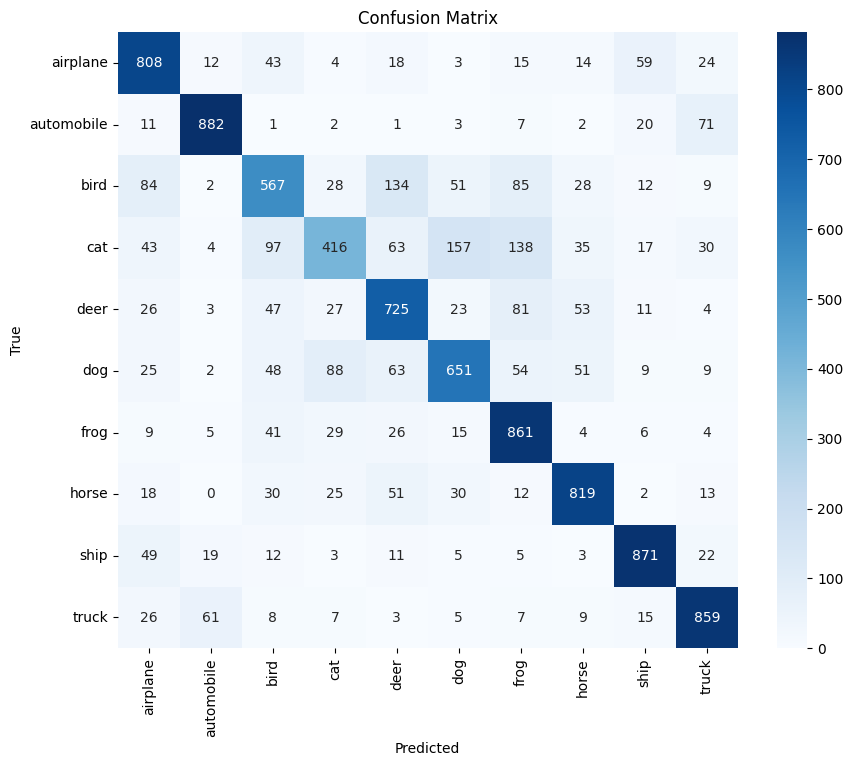

In [31]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
cm_figure = plt.gcf()
plt.show()

wandb.log({"test/confusion_matrix": wandb.Image(cm_figure)})

In [32]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
test/acc,▁
test/airplane_f1-score,▁
test/airplane_precision,▁
test/airplane_recall,▁
test/automobile_f1-score,▁
test/automobile_precision,▁
test/automobile_recall,▁
test/bird_f1-score,▁
test/bird_precision,▁
test/bird_recall,▁


# Misclassified Images

In [8]:
misclassified_train_set = TransformedDataset(dataset=train_dataset, transform=classification_test_transform)

In [9]:
misclassified_train_loader = DataLoader(
    misclassified_train_set,
    batch_size=classification_config["batch_size"],
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

In [10]:
classification_model = CNN(out_dim=len(classes)).to(device)
classification_model = nn.DataParallel(classification_model)
wandb.init(entity=classification_config["entity"], project=classification_config["project"])
artifact = wandb.use_artifact(f'{classification_config["entity"]}/{classification_config["project"]}/model:v25', type='model')
artifact_dir = artifact.download()
classification_model.load_state_dict(torch.load(os.path.join(artifact_dir, 'classification_model.pth')))
wandb.finish()

wandb:   1 of 1 files downloaded.  


In [11]:
def get_hard_neg_dict(device, model, loader):
    model.eval()

    misclassified = []

    for inputs, labels in tqdm.tqdm(loader, desc="Getting misclassified images"):
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        with torch.no_grad():
            logits = model(inputs)
            preds = logits.argmax(dim=1)

            mis_idx = (preds != labels).nonzero(as_tuple=True)[0]

            for i in mis_idx:
                misclassified.append((inputs[i].cpu(), labels[i].cpu(), preds[i].cpu()))  # (img, true_label, predicted_label)

    hard_neg_dict = {}
    for img, true_label, pred_label in misclassified:
        if pred_label.item() not in hard_neg_dict:
            hard_neg_dict[pred_label.item()] = []
        hard_neg_dict[pred_label.item()].append((img, true_label.item()))

    return hard_neg_dict

In [12]:
hard_neg_dict = get_hard_neg_dict(device, classification_model, misclassified_train_loader)

Getting misclassified images: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s]


# Contrastive Learning (Hard Negative)

In [8]:
clhn_config = {
    "entity": "project-2",
    "project": "CIFAR10-hard-negative-contrastive-learning",
    "architecture": "cnn",
    "contrast_mode": "simclr",
    "num_positives": 2,
    "num_hard_negatives": 8,
    "num_randoms": 54,
    "batch_size": 128,
    "projection_dim": 128,
    "temperature": 0.1,
    "learning_rate": 3e-5,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "num_epochs": 40
}

In [14]:
class HardNegContrastiveDataset(Dataset):
    def __init__(self, dataset, pos_transform, hard_neg_transform, hard_neg_dict, num_hard_negs, num_randoms, random_transform):
        self.dataset = dataset
        self.pos_transform = pos_transform
        self.hard_neg_transform = hard_neg_transform
        self.hard_neg_dict = hard_neg_dict
        self.num_hard_negs = num_hard_negs
        self.num_randoms = num_randoms
        self.random_transform = random_transform

    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        anchor_img, anchor_label = self.dataset[idx]
        pos_imgs = self.pos_transform(anchor_img)
        pos_imgs = torch.stack(pos_imgs, dim=0)
        pos_label = torch.tensor([anchor_label]).repeat(self.pos_transform.num_transforms)

        hard_negs = self.hard_neg_dict.get(anchor_label, [])
        hard_neg_imgs = []
        hard_neg_labels = []
        if len(hard_negs) >= self.num_hard_negs:
            hard_neg_idx = torch.randperm(len(hard_negs))[:self.num_hard_negs]
            for i in hard_neg_idx:
                img_i, label_i = hard_negs[i]
                hard_neg_imgs.append(self.hard_neg_transform(img_i))
                hard_neg_labels.append(label_i)
        else:
            for i in range(len(hard_negs)):
                img_i, label_i = hard_negs[i]
                hard_neg_imgs.append(self.hard_neg_transform(img_i))
                hard_neg_labels.append(label_i)

            num_remaining_hard_negs = self.num_hard_negs - len(hard_negs)
            neg_idx = torch.randperm(len(self.dataset))
            ctr = 0
            for i in neg_idx:
                img_i, label_i = self.dataset[i]
                if label_i == anchor_label:
                    continue
                hard_neg_imgs.append(self.random_transform(img_i))
                hard_neg_labels.append(label_i)
                ctr += 1
                if ctr == num_remaining_hard_negs:
                    break
        hard_neg_imgs = torch.stack(hard_neg_imgs, dim=0)
        hard_neg_labels = torch.tensor(hard_neg_labels)

        random_idx = torch.randperm(len(self.dataset))[:self.num_randoms]
        random_imgs = []
        random_labels = []
        for i in random_idx:
            img_i, label_i = self.dataset[i]
            random_imgs.append(self.random_transform(img_i))
            random_labels.append(label_i)
        random_imgs = torch.stack(random_imgs, dim=0)
        random_labels = torch.tensor(random_labels)

        x = torch.cat([pos_imgs, hard_neg_imgs, random_imgs], dim=0)
        y = torch.cat([pos_label, hard_neg_labels, random_labels], dim=0)

        return x, y

In [15]:
clhn_train_set = HardNegContrastiveDataset(dataset=train_dataset, 
                                           pos_transform=MultiTransform(transform=cl_train_transform, num_transforms=clhn_config['num_positives']), 
                                           hard_neg_transform=clhn_train_transform, 
                                           hard_neg_dict=hard_neg_dict,
                                           num_hard_negs=clhn_config['num_hard_negatives'],
                                           num_randoms=clhn_config['num_randoms'],
                                           random_transform=cl_train_transform)

In [16]:
clhn_train_loader = DataLoader(
    clhn_train_set,
    batch_size=clhn_config["batch_size"],
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

In [17]:
def cl_batch_log(step, log_freq, loss, optimizer):
    if step % log_freq == 0:
        wandb.log({
            "train/loss": loss,
            "train/lr": optimizer.param_groups[0]['lr'],
        })


def cl_epoch_log(epoch, num_epochs, train_loss):
    print(f"epoch [{epoch:2}/{num_epochs}] train_loss {train_loss:.4f}")
    
    wandb.log({
        "train/epoch_loss": train_loss,
        "epoch": epoch
    })

In [19]:
class HardNegContrastiveLoss(nn.Module):
    def __init__(self, contrast_mode='scl', temperature=0.07, base_temperature=0.07):
        super().__init__()
        self.contrast_mode = contrast_mode
        self.temperature = temperature
        self.base_temperature = base_temperature
        self.eps = 1e-8

    def forward(self, projs, labels):
        device = labels.device
        bsz, ne= labels.shape
        projs = F.normalize(projs, dim=-1)

        if self.contrast_mode == 'scl':
            labels = labels.contiguous()
            label_mask = (labels == labels[:, 0].view(-1, 1)).float()
            anchor_mask = torch.ones_like(label_mask, device=device)
            anchor_mask[:, 0] = 0
            pos_mask = label_mask * anchor_mask
        elif self.contrast_mode == 'simclr':
            anchor_mask = torch.ones(bsz, ne, device=device)
            anchor_mask[:, 0] = 0
            pos_mask = torch.zeros(bsz, ne, device=device)
            pos_mask[:, 1] = 1.

        anchors = projs[:, 0].unsqueeze(1)
        sims = torch.sum(anchors*projs, dim=-1)
        logits = sims / self.temperature

        logit_max, _ = torch.max(logits, dim=1, keepdim=True)
        logits_stable = logits - logit_max.detach()

        exp_logits = torch.exp(logits_stable) * anchor_mask
        log_prob = logits_stable - torch.log(exp_logits.sum(1, keepdim=True) + self.eps)

        num_pos = pos_mask.sum(1).clamp(min=self.eps)
        mean_log_prob_pos = (pos_mask * log_prob).sum(1) / num_pos

        loss = -(self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.mean()
        return loss

In [20]:
def clhn_train(epoch, loader, device, model, criterion, optimizer, scheduler, log_freq):
    model.train()
    
    total_loss = 0
    total = 0

    for step, (inputs, labels) in enumerate(tqdm.tqdm(loader, desc=f"Train epoch {epoch}")):
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        inputs = inputs.view(-1, 3, 32, 32)
        projs = model(inputs)
        projs = projs.view(labels.size(0), labels.size(1), -1)
        loss = criterion(projs, labels)        
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        total += inputs.size(0)

        cl_batch_log(step, log_freq, loss.item(), optimizer)

    if scheduler:
        scheduler.step()

    avg_loss = total_loss / total
    return avg_loss

In [21]:
clhn_model = CNN(out_dim=clhn_config['projection_dim']).to(device)
clhn_model = nn.DataParallel(clhn_model)
wandb.init(entity=cl_config["entity"], project=cl_config["project"])
artifact = wandb.use_artifact(f'{cl_config["entity"]}/{cl_config["project"]}/model:v9', type='model')
artifact_dir = artifact.download()
clhn_model.load_state_dict(torch.load(os.path.join(artifact_dir, 'cl_model.pth')))
wandb.finish()

os.makedirs('./ckpt', exist_ok=True)
clhn_model_dir = './ckpt/clhn_model.pth'

wandb:   1 of 1 files downloaded.  


In [22]:
clhn_criterion = HardNegContrastiveLoss(contrast_mode=clhn_config['contrast_mode'], temperature=clhn_config['temperature'])
clhn_optimizer = optim.Adam(clhn_model.parameters(), lr=clhn_config['learning_rate'], weight_decay=clhn_config['weight_decay'])
clhn_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(clhn_optimizer, T_max=clhn_config["num_epochs"])

In [23]:
wandb.init(entity=clhn_config["entity"], project=clhn_config["project"], config=clhn_config)

In [24]:
wandb.watch(clhn_model, log="gradients", log_freq=100)

for epoch in range(1, clhn_config['num_epochs'] + 1):
    train_loss = clhn_train(epoch, clhn_train_loader, device, clhn_model, clhn_criterion, clhn_optimizer, clhn_scheduler, log_freq=100)
    
    cl_epoch_log(epoch, clhn_config['num_epochs'], train_loss)

torch.save(clhn_model.state_dict(), clhn_model_dir)
artifact = wandb.Artifact('model', type='model')
artifact.add_file(clhn_model_dir)
wandb.log_artifact(artifact)

Train epoch 1: 100%|██████████| 313/313 [17:13<00:00,  3.30s/it]


epoch [ 1/40] train_loss 0.9984


Train epoch 2: 100%|██████████| 313/313 [17:00<00:00,  3.26s/it]


epoch [ 2/40] train_loss 1.0094


Train epoch 3: 100%|██████████| 313/313 [16:43<00:00,  3.21s/it]


epoch [ 3/40] train_loss 1.0113


Train epoch 4: 100%|██████████| 313/313 [16:39<00:00,  3.19s/it]


epoch [ 4/40] train_loss 1.0124


Train epoch 5: 100%|██████████| 313/313 [16:38<00:00,  3.19s/it]


epoch [ 5/40] train_loss 1.0310


Train epoch 6: 100%|██████████| 313/313 [16:37<00:00,  3.19s/it]


epoch [ 6/40] train_loss 0.9930


Train epoch 7: 100%|██████████| 313/313 [16:40<00:00,  3.20s/it]


epoch [ 7/40] train_loss 1.0111


Train epoch 8: 100%|██████████| 313/313 [16:37<00:00,  3.19s/it]


epoch [ 8/40] train_loss 1.0073


Train epoch 9: 100%|██████████| 313/313 [16:32<00:00,  3.17s/it]


epoch [ 9/40] train_loss 1.0025


Train epoch 10: 100%|██████████| 313/313 [16:45<00:00,  3.21s/it]


epoch [10/40] train_loss 1.0108


Train epoch 11: 100%|██████████| 313/313 [17:05<00:00,  3.28s/it]


epoch [11/40] train_loss 1.0086


Train epoch 12: 100%|██████████| 313/313 [16:57<00:00,  3.25s/it]


epoch [12/40] train_loss 1.0138


Train epoch 13: 100%|██████████| 313/313 [16:33<00:00,  3.18s/it]


epoch [13/40] train_loss 1.0056


Train epoch 14: 100%|██████████| 313/313 [16:40<00:00,  3.20s/it]


epoch [14/40] train_loss 0.9991


Train epoch 15: 100%|██████████| 313/313 [16:37<00:00,  3.19s/it]


epoch [15/40] train_loss 1.0025


Train epoch 16: 100%|██████████| 313/313 [16:33<00:00,  3.17s/it]


epoch [16/40] train_loss 1.0007


Train epoch 17: 100%|██████████| 313/313 [16:33<00:00,  3.18s/it]


epoch [17/40] train_loss 1.0021


Train epoch 18: 100%|██████████| 313/313 [16:32<00:00,  3.17s/it]


epoch [18/40] train_loss 0.9991


Train epoch 19: 100%|██████████| 313/313 [16:29<00:00,  3.16s/it]


epoch [19/40] train_loss 1.0078


Train epoch 20: 100%|██████████| 313/313 [16:50<00:00,  3.23s/it]


epoch [20/40] train_loss 1.0002


Train epoch 21: 100%|██████████| 313/313 [17:03<00:00,  3.27s/it]


epoch [21/40] train_loss 0.9934


Train epoch 22: 100%|██████████| 313/313 [16:54<00:00,  3.24s/it]


epoch [22/40] train_loss 0.9979


Train epoch 23: 100%|██████████| 313/313 [16:45<00:00,  3.21s/it]


epoch [23/40] train_loss 0.9989


Train epoch 24: 100%|██████████| 313/313 [16:23<00:00,  3.14s/it]


epoch [24/40] train_loss 0.9926


Train epoch 25: 100%|██████████| 313/313 [16:39<00:00,  3.19s/it]


epoch [25/40] train_loss 1.0012


Train epoch 26: 100%|██████████| 313/313 [16:32<00:00,  3.17s/it]


epoch [26/40] train_loss 0.9949


Train epoch 27: 100%|██████████| 313/313 [16:54<00:00,  3.24s/it]


epoch [27/40] train_loss 0.9886


Train epoch 28: 100%|██████████| 313/313 [16:49<00:00,  3.22s/it]


epoch [28/40] train_loss 0.9919


Train epoch 29: 100%|██████████| 313/313 [16:46<00:00,  3.22s/it]


epoch [29/40] train_loss 0.9941


Train epoch 30: 100%|██████████| 313/313 [16:28<00:00,  3.16s/it]


epoch [30/40] train_loss 0.9967


Train epoch 31: 100%|██████████| 313/313 [16:26<00:00,  3.15s/it]


epoch [31/40] train_loss 0.9938


Train epoch 32: 100%|██████████| 313/313 [16:40<00:00,  3.20s/it]


epoch [32/40] train_loss 1.0002


Train epoch 33: 100%|██████████| 313/313 [16:24<00:00,  3.15s/it]


epoch [33/40] train_loss 0.9991


Train epoch 34: 100%|██████████| 313/313 [16:21<00:00,  3.13s/it]


epoch [34/40] train_loss 0.9927


Train epoch 35: 100%|██████████| 313/313 [16:24<00:00,  3.15s/it]


epoch [35/40] train_loss 0.9925


Train epoch 36: 100%|██████████| 313/313 [16:21<00:00,  3.14s/it]


epoch [36/40] train_loss 1.0033


Train epoch 37: 100%|██████████| 313/313 [16:27<00:00,  3.16s/it]


epoch [37/40] train_loss 1.0007


Train epoch 38: 100%|██████████| 313/313 [16:25<00:00,  3.15s/it]


epoch [38/40] train_loss 0.9951


Train epoch 39: 100%|██████████| 313/313 [16:19<00:00,  3.13s/it]


epoch [39/40] train_loss 0.9914


Train epoch 40: 100%|██████████| 313/313 [16:22<00:00,  3.14s/it]


epoch [40/40] train_loss 0.9959


<Artifact model>

In [25]:
wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/epoch_loss,▃▄▅▅█▂▅▄▃▅▄▅▄▃▃▃▃▃▄▃▂▃▃▂▃▂▁▂▂▂▂▃▃▂▂▃▃▂▁▂
train/loss,█▄▆▄▇█▅▇▃▄▇▄▁▅▃▄▆▃▃▄▄▇▅▇▄▅▅▄▅▆█▄▇▄▅▄▅▃▅▇
train/lr,███████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
epoch,40
train/epoch_loss,0.99594
train/loss,1.13396
train/lr,0.0


# Classification (After)

In [15]:
clhn_model = CNN(out_dim=clhn_config['projection_dim']).to(device)
clhn_model = nn.DataParallel(clhn_model)
wandb.init(entity=clhn_config["entity"], project=clhn_config["project"])
artifact = wandb.use_artifact(f'{clhn_config["entity"]}/{clhn_config["project"]}/model:v3', type='model')
artifact_dir = artifact.download()
clhn_model.load_state_dict(torch.load(os.path.join(artifact_dir, 'clhn_model.pth')))
wandb.finish()

classification_model = CNN(out_dim=len(classes)).to(device)
classification_model = nn.DataParallel(classification_model)
classification_model.module.encoder = clhn_model.module.encoder
for param in classification_model.module.encoder.parameters():
    param.requires_grad = False
os.makedirs('./ckpt', exist_ok=True)
classification_model_dir = './ckpt/classification_model.pth'

wandb:   1 of 1 files downloaded.  


In [16]:
classification_criterion = nn.CrossEntropyLoss()
classification_optimizer = optim.Adam(classification_model.module.head.parameters(), lr=classification_config['learning_rate'], weight_decay=classification_config['weight_decay'])
classification_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(classification_optimizer, T_max=classification_config["num_epochs"])
classification_early_stopper = EarlyStopper(classification_model, classification_model_dir, patience=3, min_delta=0.1)

In [17]:
wandb.init(entity=classification_config['entity'], project=classification_config["project"], config=classification_config)

In [18]:
wandb.watch(classification_model, log="gradients", log_freq=10) 

for epoch in range(1, classification_config['num_epochs'] + 1):
    train_loss, train_acc = classification_train(epoch, classification_train_loader, device, classification_model, classification_criterion, classification_optimizer, classification_scheduler, log_freq=10)
    val_loss, val_acc = classification_validate(epoch, classification_val_loader, device, classification_model, classification_criterion)

    classification_epoch_log(epoch, classification_config['num_epochs'], train_loss, train_acc, val_loss, val_acc)

    if classification_early_stopper.early_stop(val_loss):
        print('early stop at epoch', epoch)
        break

artifact = wandb.Artifact('model', type='model')
artifact.add_file(classification_model_dir)
wandb.log_artifact(artifact)

Val epoch 1: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


epoch [ 1/200] train_loss 1.9500 train_acc 38.04%
epoch [ 1/200] val_loss 1.4222 val_acc 58.29%
best_val_loss 1.4222, save model!


Val epoch 2: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


epoch [ 2/200] train_loss 1.4708 train_acc 52.02%
epoch [ 2/200] val_loss 1.1640 val_acc 62.14%
best_val_loss 1.1640, save model!


Val epoch 3: 100%|██████████| 10/10 [00:01<00:00,  7.16it/s]


epoch [ 3/200] train_loss 1.3134 train_acc 55.87%
epoch [ 3/200] val_loss 1.0682 val_acc 64.22%
best_val_loss 1.0682, save model!


Val epoch 4: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


epoch [ 4/200] train_loss 1.2453 train_acc 58.10%
epoch [ 4/200] val_loss 1.0224 val_acc 65.27%
best_val_loss 1.0224, save model!


Val epoch 5: 100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


epoch [ 5/200] train_loss 1.1988 train_acc 59.08%
epoch [ 5/200] val_loss 0.9843 val_acc 66.34%
best_val_loss 0.9843, save model!


Val epoch 6: 100%|██████████| 10/10 [00:01<00:00,  7.46it/s]


epoch [ 6/200] train_loss 1.1739 train_acc 59.65%
epoch [ 6/200] val_loss 0.9686 val_acc 66.64%
best_val_loss 0.9686, save model!


Val epoch 7: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


epoch [ 7/200] train_loss 1.1522 train_acc 60.50%
epoch [ 7/200] val_loss 0.9426 val_acc 67.63%
best_val_loss 0.9426, save model!


Val epoch 8: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


epoch [ 8/200] train_loss 1.1315 train_acc 60.86%
epoch [ 8/200] val_loss 0.9307 val_acc 67.87%
best_val_loss 0.9307, save model!


Val epoch 9: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [ 9/200] train_loss 1.1136 train_acc 61.69%
epoch [ 9/200] val_loss 0.9189 val_acc 68.29%
best_val_loss 0.9189, save model!


Val epoch 10: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


epoch [10/200] train_loss 1.1020 train_acc 61.73%
epoch [10/200] val_loss 0.9029 val_acc 68.96%
best_val_loss 0.9029, save model!


Val epoch 11: 100%|██████████| 10/10 [00:01<00:00,  7.51it/s]


epoch [11/200] train_loss 1.0880 train_acc 62.48%
epoch [11/200] val_loss 0.9002 val_acc 68.74%
best_val_loss 0.9002, save model!


Val epoch 12: 100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


epoch [12/200] train_loss 1.0804 train_acc 62.85%
epoch [12/200] val_loss 0.8898 val_acc 69.12%
best_val_loss 0.8898, save model!


Val epoch 13: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


epoch [13/200] train_loss 1.0678 train_acc 63.16%
epoch [13/200] val_loss 0.8751 val_acc 69.57%
best_val_loss 0.8751, save model!


Val epoch 14: 100%|██████████| 10/10 [00:01<00:00,  6.74it/s]


epoch [14/200] train_loss 1.0620 train_acc 63.16%
epoch [14/200] val_loss 0.8683 val_acc 70.00%
best_val_loss 0.8683, save model!


Val epoch 15: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


epoch [15/200] train_loss 1.0567 train_acc 63.63%
epoch [15/200] val_loss 0.8672 val_acc 69.73%
best_val_loss 0.8672, save model!


Val epoch 16: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


epoch [16/200] train_loss 1.0497 train_acc 63.87%
epoch [16/200] val_loss 0.8589 val_acc 70.06%
best_val_loss 0.8589, save model!


Val epoch 17: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


epoch [17/200] train_loss 1.0421 train_acc 64.08%
epoch [17/200] val_loss 0.8541 val_acc 70.35%
best_val_loss 0.8541, save model!


Val epoch 18: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


epoch [18/200] train_loss 1.0336 train_acc 64.31%
epoch [18/200] val_loss 0.8478 val_acc 70.42%
best_val_loss 0.8478, save model!


Val epoch 19: 100%|██████████| 10/10 [00:01<00:00,  7.41it/s]


epoch [19/200] train_loss 1.0320 train_acc 64.27%
epoch [19/200] val_loss 0.8469 val_acc 70.45%
best_val_loss 0.8469, save model!


Val epoch 20: 100%|██████████| 10/10 [00:01<00:00,  7.49it/s]


epoch [20/200] train_loss 1.0314 train_acc 64.22%
epoch [20/200] val_loss 0.8428 val_acc 70.77%
best_val_loss 0.8428, save model!


Val epoch 21: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


epoch [21/200] train_loss 1.0199 train_acc 64.68%
epoch [21/200] val_loss 0.8355 val_acc 70.93%
best_val_loss 0.8355, save model!


Val epoch 22: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


epoch [22/200] train_loss 1.0248 train_acc 64.83%
epoch [22/200] val_loss 0.8306 val_acc 71.05%
best_val_loss 0.8306, save model!


Val epoch 23: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


epoch [23/200] train_loss 1.0145 train_acc 64.92%
epoch [23/200] val_loss 0.8263 val_acc 71.05%
best_val_loss 0.8263, save model!


Val epoch 24: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


epoch [24/200] train_loss 1.0093 train_acc 64.94%
epoch [24/200] val_loss 0.8186 val_acc 71.42%
best_val_loss 0.8186, save model!


Val epoch 25: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [25/200] train_loss 1.0084 train_acc 64.97%
epoch [25/200] val_loss 0.8251 val_acc 71.04%


Val epoch 26: 100%|██████████| 10/10 [00:01<00:00,  7.55it/s]


epoch [26/200] train_loss 1.0044 train_acc 65.46%
epoch [26/200] val_loss 0.8207 val_acc 71.31%


Val epoch 27: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [27/200] train_loss 0.9928 train_acc 65.64%
epoch [27/200] val_loss 0.8089 val_acc 71.87%
best_val_loss 0.8089, save model!


Val epoch 28: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


epoch [28/200] train_loss 0.9947 train_acc 65.44%
epoch [28/200] val_loss 0.8098 val_acc 71.83%


Val epoch 29: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


epoch [29/200] train_loss 0.9860 train_acc 65.79%
epoch [29/200] val_loss 0.8116 val_acc 71.64%


Val epoch 30: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [30/200] train_loss 0.9922 train_acc 65.52%
epoch [30/200] val_loss 0.8078 val_acc 71.76%
best_val_loss 0.8078, save model!


Val epoch 31: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


epoch [31/200] train_loss 0.9876 train_acc 65.56%
epoch [31/200] val_loss 0.8063 val_acc 71.88%
best_val_loss 0.8063, save model!


Val epoch 32: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [32/200] train_loss 0.9765 train_acc 66.08%
epoch [32/200] val_loss 0.7996 val_acc 71.98%
best_val_loss 0.7996, save model!


Val epoch 33: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


epoch [33/200] train_loss 0.9825 train_acc 66.20%
epoch [33/200] val_loss 0.8063 val_acc 71.88%


Val epoch 34: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [34/200] train_loss 0.9743 train_acc 66.11%
epoch [34/200] val_loss 0.7966 val_acc 72.23%
best_val_loss 0.7966, save model!


Val epoch 35: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [35/200] train_loss 0.9739 train_acc 66.16%
epoch [35/200] val_loss 0.8006 val_acc 72.11%


Val epoch 36: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [36/200] train_loss 0.9740 train_acc 66.14%
epoch [36/200] val_loss 0.7938 val_acc 72.30%
best_val_loss 0.7938, save model!


Val epoch 37: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [37/200] train_loss 0.9733 train_acc 66.43%
epoch [37/200] val_loss 0.7914 val_acc 72.31%
best_val_loss 0.7914, save model!


Val epoch 38: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


epoch [38/200] train_loss 0.9679 train_acc 66.21%
epoch [38/200] val_loss 0.7860 val_acc 72.48%
best_val_loss 0.7860, save model!


Val epoch 39: 100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


epoch [39/200] train_loss 0.9604 train_acc 66.75%
epoch [39/200] val_loss 0.7890 val_acc 72.26%


Val epoch 40: 100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


epoch [40/200] train_loss 0.9602 train_acc 66.68%
epoch [40/200] val_loss 0.7888 val_acc 72.47%


Val epoch 41: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


epoch [41/200] train_loss 0.9597 train_acc 66.64%
epoch [41/200] val_loss 0.7846 val_acc 72.62%
best_val_loss 0.7846, save model!


Val epoch 42: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [42/200] train_loss 0.9585 train_acc 66.54%
epoch [42/200] val_loss 0.7846 val_acc 72.58%


Val epoch 43: 100%|██████████| 10/10 [00:01<00:00,  7.44it/s]


epoch [43/200] train_loss 0.9577 train_acc 66.91%
epoch [43/200] val_loss 0.7867 val_acc 72.49%


Val epoch 44: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


epoch [44/200] train_loss 0.9520 train_acc 66.81%
epoch [44/200] val_loss 0.7776 val_acc 72.68%
best_val_loss 0.7776, save model!


Val epoch 45: 100%|██████████| 10/10 [00:01<00:00,  7.43it/s]


epoch [45/200] train_loss 0.9546 train_acc 66.89%
epoch [45/200] val_loss 0.7765 val_acc 72.83%
best_val_loss 0.7765, save model!


Val epoch 46: 100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


epoch [46/200] train_loss 0.9510 train_acc 66.80%
epoch [46/200] val_loss 0.7750 val_acc 72.97%
best_val_loss 0.7750, save model!


Val epoch 47: 100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


epoch [47/200] train_loss 0.9520 train_acc 67.08%
epoch [47/200] val_loss 0.7718 val_acc 72.88%
best_val_loss 0.7718, save model!


Val epoch 48: 100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


epoch [48/200] train_loss 0.9447 train_acc 67.34%
epoch [48/200] val_loss 0.7700 val_acc 72.87%
best_val_loss 0.7700, save model!


Val epoch 49: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [49/200] train_loss 0.9459 train_acc 67.05%
epoch [49/200] val_loss 0.7699 val_acc 73.15%
best_val_loss 0.7699, save model!


Val epoch 50: 100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


epoch [50/200] train_loss 0.9472 train_acc 67.04%
epoch [50/200] val_loss 0.7669 val_acc 73.29%
best_val_loss 0.7669, save model!


Val epoch 51: 100%|██████████| 10/10 [00:01<00:00,  7.42it/s]


epoch [51/200] train_loss 0.9443 train_acc 67.26%
epoch [51/200] val_loss 0.7635 val_acc 73.31%
best_val_loss 0.7635, save model!


Val epoch 52: 100%|██████████| 10/10 [00:01<00:00,  7.16it/s]


epoch [52/200] train_loss 0.9374 train_acc 67.39%
epoch [52/200] val_loss 0.7668 val_acc 73.13%


Val epoch 53: 100%|██████████| 10/10 [00:01<00:00,  7.38it/s]


epoch [53/200] train_loss 0.9385 train_acc 67.34%
epoch [53/200] val_loss 0.7688 val_acc 73.11%


Val epoch 54: 100%|██████████| 10/10 [00:01<00:00,  7.57it/s]


epoch [54/200] train_loss 0.9386 train_acc 67.30%
epoch [54/200] val_loss 0.7664 val_acc 73.10%


Val epoch 55: 100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


epoch [55/200] train_loss 0.9401 train_acc 67.25%
epoch [55/200] val_loss 0.7652 val_acc 72.99%


Val epoch 56: 100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


epoch [56/200] train_loss 0.9351 train_acc 67.66%
epoch [56/200] val_loss 0.7632 val_acc 73.34%
best_val_loss 0.7632, save model!


Val epoch 57: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


epoch [57/200] train_loss 0.9341 train_acc 67.72%
epoch [57/200] val_loss 0.7618 val_acc 73.27%
best_val_loss 0.7618, save model!


Val epoch 58: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [58/200] train_loss 0.9341 train_acc 67.71%
epoch [58/200] val_loss 0.7650 val_acc 73.08%


Val epoch 59: 100%|██████████| 10/10 [00:01<00:00,  7.35it/s]


epoch [59/200] train_loss 0.9288 train_acc 67.66%
epoch [59/200] val_loss 0.7544 val_acc 73.46%
best_val_loss 0.7544, save model!


Val epoch 60: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


epoch [60/200] train_loss 0.9312 train_acc 67.52%
epoch [60/200] val_loss 0.7540 val_acc 73.66%
best_val_loss 0.7540, save model!


Val epoch 61: 100%|██████████| 10/10 [00:01<00:00,  6.94it/s]


epoch [61/200] train_loss 0.9275 train_acc 67.68%
epoch [61/200] val_loss 0.7514 val_acc 73.68%
best_val_loss 0.7514, save model!


Val epoch 62: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [62/200] train_loss 0.9250 train_acc 67.82%
epoch [62/200] val_loss 0.7525 val_acc 73.53%


Val epoch 63: 100%|██████████| 10/10 [00:01<00:00,  7.27it/s]


epoch [63/200] train_loss 0.9261 train_acc 67.85%
epoch [63/200] val_loss 0.7565 val_acc 73.47%


Val epoch 64: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


epoch [64/200] train_loss 0.9277 train_acc 67.75%
epoch [64/200] val_loss 0.7502 val_acc 73.61%
best_val_loss 0.7502, save model!


Val epoch 65: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [65/200] train_loss 0.9231 train_acc 67.95%
epoch [65/200] val_loss 0.7530 val_acc 73.66%


Val epoch 66: 100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


epoch [66/200] train_loss 0.9181 train_acc 68.06%
epoch [66/200] val_loss 0.7512 val_acc 73.47%


Val epoch 67: 100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


epoch [67/200] train_loss 0.9219 train_acc 68.15%
epoch [67/200] val_loss 0.7529 val_acc 73.54%


Val epoch 68: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


epoch [68/200] train_loss 0.9169 train_acc 68.22%
epoch [68/200] val_loss 0.7468 val_acc 73.77%
best_val_loss 0.7468, save model!


Val epoch 69: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [69/200] train_loss 0.9161 train_acc 68.18%
epoch [69/200] val_loss 0.7440 val_acc 73.59%
best_val_loss 0.7440, save model!


Val epoch 70: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [70/200] train_loss 0.9173 train_acc 68.00%
epoch [70/200] val_loss 0.7524 val_acc 73.50%


Val epoch 71: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [71/200] train_loss 0.9108 train_acc 68.25%
epoch [71/200] val_loss 0.7467 val_acc 73.72%


Val epoch 72: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [72/200] train_loss 0.9155 train_acc 68.06%
epoch [72/200] val_loss 0.7449 val_acc 73.79%


Val epoch 73: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


epoch [73/200] train_loss 0.9147 train_acc 68.31%
epoch [73/200] val_loss 0.7452 val_acc 73.83%


Val epoch 74: 100%|██████████| 10/10 [00:01<00:00,  7.47it/s]


epoch [74/200] train_loss 0.9132 train_acc 68.34%
epoch [74/200] val_loss 0.7447 val_acc 73.73%


Val epoch 75: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [75/200] train_loss 0.9143 train_acc 68.07%
epoch [75/200] val_loss 0.7428 val_acc 73.91%
best_val_loss 0.7428, save model!


Val epoch 76: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [76/200] train_loss 0.9100 train_acc 68.36%
epoch [76/200] val_loss 0.7438 val_acc 73.79%


Val epoch 77: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [77/200] train_loss 0.9068 train_acc 68.50%
epoch [77/200] val_loss 0.7410 val_acc 74.03%
best_val_loss 0.7410, save model!


Val epoch 78: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [78/200] train_loss 0.9087 train_acc 68.54%
epoch [78/200] val_loss 0.7425 val_acc 73.88%


Val epoch 79: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [79/200] train_loss 0.9089 train_acc 68.44%
epoch [79/200] val_loss 0.7379 val_acc 73.84%
best_val_loss 0.7379, save model!


Val epoch 80: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [80/200] train_loss 0.9035 train_acc 68.69%
epoch [80/200] val_loss 0.7379 val_acc 73.83%


Val epoch 81: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


epoch [81/200] train_loss 0.9066 train_acc 68.50%
epoch [81/200] val_loss 0.7361 val_acc 73.82%
best_val_loss 0.7361, save model!


Val epoch 82: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [82/200] train_loss 0.9083 train_acc 68.34%
epoch [82/200] val_loss 0.7363 val_acc 73.85%


Val epoch 83: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [83/200] train_loss 0.9016 train_acc 68.69%
epoch [83/200] val_loss 0.7382 val_acc 73.89%


Val epoch 84: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


epoch [84/200] train_loss 0.9039 train_acc 68.62%
epoch [84/200] val_loss 0.7338 val_acc 74.09%
best_val_loss 0.7338, save model!


Val epoch 85: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


epoch [85/200] train_loss 0.9052 train_acc 68.62%
epoch [85/200] val_loss 0.7362 val_acc 73.91%


Val epoch 86: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [86/200] train_loss 0.9029 train_acc 68.71%
epoch [86/200] val_loss 0.7370 val_acc 73.83%


Val epoch 87: 100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


epoch [87/200] train_loss 0.9013 train_acc 68.60%
epoch [87/200] val_loss 0.7321 val_acc 74.18%
best_val_loss 0.7321, save model!


Val epoch 88: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [88/200] train_loss 0.9003 train_acc 68.44%
epoch [88/200] val_loss 0.7270 val_acc 74.22%
best_val_loss 0.7270, save model!


Val epoch 89: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


epoch [89/200] train_loss 0.8968 train_acc 68.70%
epoch [89/200] val_loss 0.7282 val_acc 74.27%


Val epoch 90: 100%|██████████| 10/10 [00:01<00:00,  7.31it/s]


epoch [90/200] train_loss 0.8993 train_acc 68.94%
epoch [90/200] val_loss 0.7330 val_acc 74.10%


Val epoch 91: 100%|██████████| 10/10 [00:01<00:00,  7.32it/s]


epoch [91/200] train_loss 0.8945 train_acc 69.11%
epoch [91/200] val_loss 0.7309 val_acc 74.23%


Val epoch 92: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


epoch [92/200] train_loss 0.8940 train_acc 69.01%
epoch [92/200] val_loss 0.7330 val_acc 74.19%


Val epoch 93: 100%|██████████| 10/10 [00:01<00:00,  6.96it/s]


epoch [93/200] train_loss 0.8934 train_acc 68.79%
epoch [93/200] val_loss 0.7352 val_acc 74.00%


Val epoch 94: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [94/200] train_loss 0.8967 train_acc 68.74%
epoch [94/200] val_loss 0.7287 val_acc 74.27%


Val epoch 95: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [95/200] train_loss 0.8936 train_acc 68.95%
epoch [95/200] val_loss 0.7299 val_acc 74.10%


Val epoch 96: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


epoch [96/200] train_loss 0.8898 train_acc 69.29%
epoch [96/200] val_loss 0.7278 val_acc 74.16%


Val epoch 97: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


epoch [97/200] train_loss 0.8900 train_acc 69.02%
epoch [97/200] val_loss 0.7261 val_acc 74.40%
best_val_loss 0.7261, save model!


Val epoch 98: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [98/200] train_loss 0.8897 train_acc 68.94%
epoch [98/200] val_loss 0.7313 val_acc 74.18%


Val epoch 99: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [99/200] train_loss 0.8889 train_acc 69.04%
epoch [99/200] val_loss 0.7243 val_acc 74.47%
best_val_loss 0.7243, save model!


Val epoch 100: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [100/200] train_loss 0.8936 train_acc 69.01%
epoch [100/200] val_loss 0.7266 val_acc 74.57%


Val epoch 101: 100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


epoch [101/200] train_loss 0.8902 train_acc 69.05%
epoch [101/200] val_loss 0.7232 val_acc 74.53%
best_val_loss 0.7232, save model!


Val epoch 102: 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


epoch [102/200] train_loss 0.8878 train_acc 69.08%
epoch [102/200] val_loss 0.7204 val_acc 74.63%
best_val_loss 0.7204, save model!


Val epoch 103: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [103/200] train_loss 0.8795 train_acc 69.37%
epoch [103/200] val_loss 0.7213 val_acc 74.49%


Val epoch 104: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [104/200] train_loss 0.8839 train_acc 68.99%
epoch [104/200] val_loss 0.7213 val_acc 74.65%


Val epoch 105: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [105/200] train_loss 0.8851 train_acc 69.10%
epoch [105/200] val_loss 0.7209 val_acc 74.58%


Val epoch 106: 100%|██████████| 10/10 [00:01<00:00,  6.86it/s]


epoch [106/200] train_loss 0.8838 train_acc 69.54%
epoch [106/200] val_loss 0.7219 val_acc 74.61%


Val epoch 107: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [107/200] train_loss 0.8876 train_acc 69.38%
epoch [107/200] val_loss 0.7256 val_acc 74.37%


Val epoch 108: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [108/200] train_loss 0.8868 train_acc 69.16%
epoch [108/200] val_loss 0.7219 val_acc 74.64%


Val epoch 109: 100%|██████████| 10/10 [00:01<00:00,  6.91it/s]


epoch [109/200] train_loss 0.8829 train_acc 69.40%
epoch [109/200] val_loss 0.7211 val_acc 74.69%


Val epoch 110: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [110/200] train_loss 0.8851 train_acc 69.21%
epoch [110/200] val_loss 0.7246 val_acc 74.46%


Val epoch 111: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [111/200] train_loss 0.8839 train_acc 69.17%
epoch [111/200] val_loss 0.7218 val_acc 74.51%


Val epoch 112: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [112/200] train_loss 0.8855 train_acc 69.16%
epoch [112/200] val_loss 0.7231 val_acc 74.36%


Val epoch 113: 100%|██████████| 10/10 [00:01<00:00,  6.90it/s]


epoch [113/200] train_loss 0.8825 train_acc 69.49%
epoch [113/200] val_loss 0.7222 val_acc 74.62%


Val epoch 114: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [114/200] train_loss 0.8835 train_acc 69.17%
epoch [114/200] val_loss 0.7202 val_acc 74.66%
best_val_loss 0.7202, save model!


Val epoch 115: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [115/200] train_loss 0.8829 train_acc 69.25%
epoch [115/200] val_loss 0.7153 val_acc 74.65%
best_val_loss 0.7153, save model!


Val epoch 116: 100%|██████████| 10/10 [00:01<00:00,  6.57it/s]


epoch [116/200] train_loss 0.8807 train_acc 69.34%
epoch [116/200] val_loss 0.7181 val_acc 74.63%


Val epoch 117: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [117/200] train_loss 0.8774 train_acc 69.59%
epoch [117/200] val_loss 0.7184 val_acc 74.78%


Val epoch 118: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [118/200] train_loss 0.8806 train_acc 69.31%
epoch [118/200] val_loss 0.7199 val_acc 74.60%


Val epoch 119: 100%|██████████| 10/10 [00:01<00:00,  6.51it/s]


epoch [119/200] train_loss 0.8828 train_acc 69.03%
epoch [119/200] val_loss 0.7203 val_acc 74.59%


Val epoch 120: 100%|██████████| 10/10 [00:01<00:00,  7.07it/s]


epoch [120/200] train_loss 0.8793 train_acc 69.66%
epoch [120/200] val_loss 0.7213 val_acc 74.47%


Val epoch 121: 100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


epoch [121/200] train_loss 0.8792 train_acc 69.38%
epoch [121/200] val_loss 0.7165 val_acc 74.80%


Val epoch 122: 100%|██████████| 10/10 [00:01<00:00,  6.97it/s]


epoch [122/200] train_loss 0.8760 train_acc 69.25%
epoch [122/200] val_loss 0.7154 val_acc 74.86%


Val epoch 123: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


epoch [123/200] train_loss 0.8742 train_acc 69.69%
epoch [123/200] val_loss 0.7177 val_acc 74.75%


Val epoch 124: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


epoch [124/200] train_loss 0.8758 train_acc 69.46%
epoch [124/200] val_loss 0.7178 val_acc 74.69%


Val epoch 125: 100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


epoch [125/200] train_loss 0.8783 train_acc 69.48%
epoch [125/200] val_loss 0.7186 val_acc 74.79%


Val epoch 126: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [126/200] train_loss 0.8777 train_acc 69.50%
epoch [126/200] val_loss 0.7138 val_acc 74.89%
best_val_loss 0.7138, save model!


Val epoch 127: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


epoch [127/200] train_loss 0.8759 train_acc 69.61%
epoch [127/200] val_loss 0.7147 val_acc 74.77%


Val epoch 128: 100%|██████████| 10/10 [00:01<00:00,  7.21it/s]


epoch [128/200] train_loss 0.8747 train_acc 69.85%
epoch [128/200] val_loss 0.7160 val_acc 74.81%


Val epoch 129: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [129/200] train_loss 0.8780 train_acc 69.66%
epoch [129/200] val_loss 0.7146 val_acc 74.89%


Val epoch 130: 100%|██████████| 10/10 [00:01<00:00,  7.29it/s]


epoch [130/200] train_loss 0.8748 train_acc 69.81%
epoch [130/200] val_loss 0.7181 val_acc 74.66%


Val epoch 131: 100%|██████████| 10/10 [00:01<00:00,  6.16it/s]


epoch [131/200] train_loss 0.8783 train_acc 69.52%
epoch [131/200] val_loss 0.7125 val_acc 74.93%
best_val_loss 0.7125, save model!


Val epoch 132: 100%|██████████| 10/10 [00:01<00:00,  6.77it/s]


epoch [132/200] train_loss 0.8719 train_acc 69.66%
epoch [132/200] val_loss 0.7127 val_acc 74.87%


Val epoch 133: 100%|██████████| 10/10 [00:01<00:00,  7.08it/s]


epoch [133/200] train_loss 0.8667 train_acc 69.78%
epoch [133/200] val_loss 0.7156 val_acc 74.75%


Val epoch 134: 100%|██████████| 10/10 [00:01<00:00,  7.01it/s]


epoch [134/200] train_loss 0.8703 train_acc 69.47%
epoch [134/200] val_loss 0.7152 val_acc 74.85%


Val epoch 135: 100%|██████████| 10/10 [00:01<00:00,  6.01it/s]


epoch [135/200] train_loss 0.8697 train_acc 69.74%
epoch [135/200] val_loss 0.7142 val_acc 74.92%


Val epoch 136: 100%|██████████| 10/10 [00:01<00:00,  7.19it/s]


epoch [136/200] train_loss 0.8721 train_acc 69.72%
epoch [136/200] val_loss 0.7125 val_acc 75.02%


Val epoch 137: 100%|██████████| 10/10 [00:01<00:00,  7.06it/s]


epoch [137/200] train_loss 0.8713 train_acc 69.53%
epoch [137/200] val_loss 0.7106 val_acc 74.93%
best_val_loss 0.7106, save model!


Val epoch 138: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


epoch [138/200] train_loss 0.8706 train_acc 69.72%
epoch [138/200] val_loss 0.7143 val_acc 74.88%


Val epoch 139: 100%|██████████| 10/10 [00:01<00:00,  5.86it/s]


epoch [139/200] train_loss 0.8723 train_acc 69.79%
epoch [139/200] val_loss 0.7111 val_acc 74.95%


Val epoch 140: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


epoch [140/200] train_loss 0.8776 train_acc 69.39%
epoch [140/200] val_loss 0.7110 val_acc 74.96%


Val epoch 141: 100%|██████████| 10/10 [00:01<00:00,  7.40it/s]


epoch [141/200] train_loss 0.8740 train_acc 69.47%
epoch [141/200] val_loss 0.7097 val_acc 75.10%
best_val_loss 0.7097, save model!


Val epoch 142: 100%|██████████| 10/10 [00:01<00:00,  6.98it/s]


epoch [142/200] train_loss 0.8671 train_acc 69.54%
epoch [142/200] val_loss 0.7116 val_acc 75.00%


Val epoch 143: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


epoch [143/200] train_loss 0.8767 train_acc 69.60%
epoch [143/200] val_loss 0.7115 val_acc 74.85%


Val epoch 144: 100%|██████████| 10/10 [00:01<00:00,  7.36it/s]


epoch [144/200] train_loss 0.8724 train_acc 69.69%
epoch [144/200] val_loss 0.7113 val_acc 75.00%


Val epoch 145: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [145/200] train_loss 0.8708 train_acc 69.82%
epoch [145/200] val_loss 0.7114 val_acc 74.91%


Val epoch 146: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [146/200] train_loss 0.8631 train_acc 69.77%
epoch [146/200] val_loss 0.7112 val_acc 74.99%


Val epoch 147: 100%|██████████| 10/10 [00:01<00:00,  5.75it/s]


epoch [147/200] train_loss 0.8717 train_acc 69.66%
epoch [147/200] val_loss 0.7119 val_acc 74.92%


Val epoch 148: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [148/200] train_loss 0.8670 train_acc 69.92%
epoch [148/200] val_loss 0.7113 val_acc 74.99%


Val epoch 149: 100%|██████████| 10/10 [00:01<00:00,  7.15it/s]


epoch [149/200] train_loss 0.8708 train_acc 69.61%
epoch [149/200] val_loss 0.7122 val_acc 74.97%


Val epoch 150: 100%|██████████| 10/10 [00:01<00:00,  7.14it/s]


epoch [150/200] train_loss 0.8621 train_acc 69.87%
epoch [150/200] val_loss 0.7096 val_acc 74.98%
best_val_loss 0.7096, save model!


Val epoch 151: 100%|██████████| 10/10 [00:01<00:00,  6.20it/s]


epoch [151/200] train_loss 0.8641 train_acc 69.93%
epoch [151/200] val_loss 0.7125 val_acc 74.99%


Val epoch 152: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [152/200] train_loss 0.8656 train_acc 70.08%
epoch [152/200] val_loss 0.7091 val_acc 74.99%
best_val_loss 0.7091, save model!


Val epoch 153: 100%|██████████| 10/10 [00:01<00:00,  7.23it/s]


epoch [153/200] train_loss 0.8716 train_acc 69.47%
epoch [153/200] val_loss 0.7104 val_acc 74.98%


Val epoch 154: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [154/200] train_loss 0.8704 train_acc 69.62%
epoch [154/200] val_loss 0.7104 val_acc 75.03%


Val epoch 155: 100%|██████████| 10/10 [00:01<00:00,  5.80it/s]


epoch [155/200] train_loss 0.8701 train_acc 69.71%
epoch [155/200] val_loss 0.7096 val_acc 74.97%


Val epoch 156: 100%|██████████| 10/10 [00:01<00:00,  7.50it/s]


epoch [156/200] train_loss 0.8686 train_acc 69.69%
epoch [156/200] val_loss 0.7106 val_acc 74.97%


Val epoch 157: 100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


epoch [157/200] train_loss 0.8685 train_acc 69.92%
epoch [157/200] val_loss 0.7085 val_acc 74.99%
best_val_loss 0.7085, save model!


Val epoch 158: 100%|██████████| 10/10 [00:01<00:00,  7.22it/s]


epoch [158/200] train_loss 0.8666 train_acc 69.74%
epoch [158/200] val_loss 0.7109 val_acc 75.05%


Val epoch 159: 100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


epoch [159/200] train_loss 0.8677 train_acc 69.96%
epoch [159/200] val_loss 0.7088 val_acc 75.10%


Val epoch 160: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [160/200] train_loss 0.8686 train_acc 69.79%
epoch [160/200] val_loss 0.7101 val_acc 75.03%


Val epoch 161: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [161/200] train_loss 0.8685 train_acc 69.75%
epoch [161/200] val_loss 0.7085 val_acc 75.12%
best_val_loss 0.7085, save model!


Val epoch 162: 100%|██████████| 10/10 [00:01<00:00,  6.84it/s]


epoch [162/200] train_loss 0.8658 train_acc 69.88%
epoch [162/200] val_loss 0.7079 val_acc 75.12%
best_val_loss 0.7079, save model!


Val epoch 163: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


epoch [163/200] train_loss 0.8671 train_acc 69.83%
epoch [163/200] val_loss 0.7102 val_acc 75.07%


Val epoch 164: 100%|██████████| 10/10 [00:01<00:00,  7.13it/s]


epoch [164/200] train_loss 0.8692 train_acc 69.91%
epoch [164/200] val_loss 0.7098 val_acc 75.03%


Val epoch 165: 100%|██████████| 10/10 [00:01<00:00,  7.17it/s]


epoch [165/200] train_loss 0.8630 train_acc 69.91%
epoch [165/200] val_loss 0.7072 val_acc 75.16%
best_val_loss 0.7072, save model!


Val epoch 166: 100%|██████████| 10/10 [00:01<00:00,  7.34it/s]


epoch [166/200] train_loss 0.8646 train_acc 69.90%
epoch [166/200] val_loss 0.7084 val_acc 75.05%


Val epoch 167: 100%|██████████| 10/10 [00:01<00:00,  5.77it/s]


epoch [167/200] train_loss 0.8641 train_acc 69.92%
epoch [167/200] val_loss 0.7083 val_acc 75.16%


Val epoch 168: 100%|██████████| 10/10 [00:01<00:00,  6.88it/s]


epoch [168/200] train_loss 0.8612 train_acc 70.02%
epoch [168/200] val_loss 0.7091 val_acc 75.00%


Val epoch 169: 100%|██████████| 10/10 [00:01<00:00,  7.28it/s]


epoch [169/200] train_loss 0.8640 train_acc 70.03%
epoch [169/200] val_loss 0.7081 val_acc 75.17%


Val epoch 170: 100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


epoch [170/200] train_loss 0.8586 train_acc 70.31%
epoch [170/200] val_loss 0.7119 val_acc 74.87%


Val epoch 171: 100%|██████████| 10/10 [00:01<00:00,  5.92it/s]


epoch [171/200] train_loss 0.8615 train_acc 70.20%
epoch [171/200] val_loss 0.7087 val_acc 75.03%


Val epoch 172: 100%|██████████| 10/10 [00:01<00:00,  7.30it/s]


epoch [172/200] train_loss 0.8633 train_acc 69.97%
epoch [172/200] val_loss 0.7095 val_acc 75.03%


Val epoch 173: 100%|██████████| 10/10 [00:01<00:00,  6.99it/s]


epoch [173/200] train_loss 0.8659 train_acc 69.86%
epoch [173/200] val_loss 0.7072 val_acc 75.16%


Val epoch 174: 100%|██████████| 10/10 [00:01<00:00,  6.92it/s]


epoch [174/200] train_loss 0.8655 train_acc 70.01%
epoch [174/200] val_loss 0.7094 val_acc 74.95%


Val epoch 175: 100%|██████████| 10/10 [00:01<00:00,  5.57it/s]


epoch [175/200] train_loss 0.8666 train_acc 69.94%
epoch [175/200] val_loss 0.7078 val_acc 75.03%


Val epoch 176: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [176/200] train_loss 0.8659 train_acc 69.71%
epoch [176/200] val_loss 0.7072 val_acc 74.93%
best_val_loss 0.7072, save model!


Val epoch 177: 100%|██████████| 10/10 [00:01<00:00,  7.03it/s]


epoch [177/200] train_loss 0.8663 train_acc 69.94%
epoch [177/200] val_loss 0.7085 val_acc 75.02%


Val epoch 178: 100%|██████████| 10/10 [00:01<00:00,  7.25it/s]


epoch [178/200] train_loss 0.8687 train_acc 69.70%
epoch [178/200] val_loss 0.7076 val_acc 75.12%


Val epoch 179: 100%|██████████| 10/10 [00:01<00:00,  5.64it/s]


epoch [179/200] train_loss 0.8630 train_acc 69.92%
epoch [179/200] val_loss 0.7080 val_acc 75.06%


Val epoch 180: 100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


epoch [180/200] train_loss 0.8642 train_acc 69.79%
epoch [180/200] val_loss 0.7097 val_acc 75.07%


Val epoch 181: 100%|██████████| 10/10 [00:01<00:00,  7.12it/s]


epoch [181/200] train_loss 0.8608 train_acc 69.83%
epoch [181/200] val_loss 0.7085 val_acc 74.99%


Val epoch 182: 100%|██████████| 10/10 [00:01<00:00,  7.00it/s]


epoch [182/200] train_loss 0.8658 train_acc 70.01%
epoch [182/200] val_loss 0.7077 val_acc 75.13%


Val epoch 183: 100%|██████████| 10/10 [00:01<00:00,  5.67it/s]


epoch [183/200] train_loss 0.8633 train_acc 69.95%
epoch [183/200] val_loss 0.7081 val_acc 75.06%


Val epoch 184: 100%|██████████| 10/10 [00:01<00:00,  7.02it/s]


epoch [184/200] train_loss 0.8635 train_acc 69.90%
epoch [184/200] val_loss 0.7094 val_acc 74.91%


Val epoch 185: 100%|██████████| 10/10 [00:01<00:00,  7.05it/s]


epoch [185/200] train_loss 0.8624 train_acc 70.05%
epoch [185/200] val_loss 0.7090 val_acc 75.04%


Val epoch 186: 100%|██████████| 10/10 [00:01<00:00,  7.09it/s]


epoch [186/200] train_loss 0.8649 train_acc 69.91%
epoch [186/200] val_loss 0.7080 val_acc 75.03%


Val epoch 187: 100%|██████████| 10/10 [00:01<00:00,  5.68it/s]


epoch [187/200] train_loss 0.8587 train_acc 70.20%
epoch [187/200] val_loss 0.7087 val_acc 75.08%


Val epoch 188: 100%|██████████| 10/10 [00:01<00:00,  7.10it/s]


epoch [188/200] train_loss 0.8626 train_acc 69.81%
epoch [188/200] val_loss 0.7058 val_acc 75.19%
best_val_loss 0.7058, save model!


Val epoch 189: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]


epoch [189/200] train_loss 0.8624 train_acc 70.20%
epoch [189/200] val_loss 0.7090 val_acc 75.07%


Val epoch 190: 100%|██████████| 10/10 [00:01<00:00,  7.39it/s]


epoch [190/200] train_loss 0.8660 train_acc 69.92%
epoch [190/200] val_loss 0.7090 val_acc 75.06%


Val epoch 191: 100%|██████████| 10/10 [00:01<00:00,  5.61it/s]


epoch [191/200] train_loss 0.8642 train_acc 69.94%
epoch [191/200] val_loss 0.7080 val_acc 75.17%


Val epoch 192: 100%|██████████| 10/10 [00:01<00:00,  6.87it/s]


epoch [192/200] train_loss 0.8632 train_acc 70.18%
epoch [192/200] val_loss 0.7083 val_acc 75.03%


Val epoch 193: 100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


epoch [193/200] train_loss 0.8674 train_acc 70.10%
epoch [193/200] val_loss 0.7071 val_acc 75.15%


Val epoch 194: 100%|██████████| 10/10 [00:01<00:00,  6.78it/s]


epoch [194/200] train_loss 0.8704 train_acc 69.88%
epoch [194/200] val_loss 0.7092 val_acc 74.93%


Val epoch 195: 100%|██████████| 10/10 [00:01<00:00,  5.81it/s]


epoch [195/200] train_loss 0.8642 train_acc 69.98%
epoch [195/200] val_loss 0.7084 val_acc 75.14%


Val epoch 196: 100%|██████████| 10/10 [00:01<00:00,  7.26it/s]


epoch [196/200] train_loss 0.8607 train_acc 70.07%
epoch [196/200] val_loss 0.7067 val_acc 75.13%


Val epoch 197: 100%|██████████| 10/10 [00:01<00:00,  5.90it/s]


epoch [197/200] train_loss 0.8637 train_acc 70.10%
epoch [197/200] val_loss 0.7076 val_acc 75.04%


Val epoch 198: 100%|██████████| 10/10 [00:01<00:00,  7.20it/s]


epoch [198/200] train_loss 0.8696 train_acc 69.81%
epoch [198/200] val_loss 0.7085 val_acc 75.10%


Val epoch 199: 100%|██████████| 10/10 [00:01<00:00,  5.74it/s]


epoch [199/200] train_loss 0.8661 train_acc 70.06%
epoch [199/200] val_loss 0.7068 val_acc 75.09%


Val epoch 200: 100%|██████████| 10/10 [00:01<00:00,  7.11it/s]

epoch [200/200] train_loss 0.8663 train_acc 69.92%
epoch [200/200] val_loss 0.7076 val_acc 75.07%


<Artifact model>

In [19]:
classification_model.load_state_dict(torch.load(classification_model_dir))

<All keys matched successfully>

In [20]:
def classification_test(loader, device, model, criterion):
    model.eval()
    
    total_loss = 0
    correct = 0
    total = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in tqdm.tqdm(loader):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            logits = model(inputs)
            loss = criterion(logits, labels)

            total_loss += loss.item() * labels.size(0)
            _, predicted = logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            y_true.append(labels)
            y_pred.append(predicted)

    avg_loss = total_loss / total
    acc = 100. * correct / total

    y_true = torch.cat(y_true, dim=0).to('cpu').numpy()
    y_pred = torch.cat(y_pred, dim=0).to('cpu').numpy()
    
    return avg_loss, acc, y_true, y_pred

In [21]:
test_loss, test_acc, y_true, y_pred = classification_test(classification_test_loader, device, classification_model, classification_criterion)
print(f"test_loss {test_loss:.4f} test acc {test_acc:.2f}%")

wandb.log({
    "test/loss": test_loss,
    "test/acc":  test_acc
})

100%|██████████| 10/10 [00:01<00:00,  6.70it/s]

test_loss 0.7181 test acc 74.95%


In [22]:
print(classification_report(y_true, y_pred))

class_report = classification_report(y_true, y_pred, output_dict=True)
wandb.log({    
    **{f"test/{cls}_precision": class_report[str(idx)]['precision'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_recall": class_report[str(idx)]['recall'] for idx, cls in enumerate(classes)},
    **{f"test/{cls}_f1-score": class_report[str(idx)]['f1-score'] for idx, cls in enumerate(classes)}
})

              precision    recall  f1-score   support

           0       0.74      0.81      0.77      1000
           1       0.88      0.89      0.89      1000
           2       0.65      0.57      0.60      1000
           3       0.67      0.42      0.52      1000
           4       0.65      0.73      0.69      1000
           5       0.69      0.66      0.67      1000
           6       0.69      0.86      0.77      1000
           7       0.81      0.82      0.82      1000
           8       0.85      0.87      0.86      1000
           9       0.83      0.86      0.85      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.74     10000
weighted avg       0.75      0.75      0.74     10000



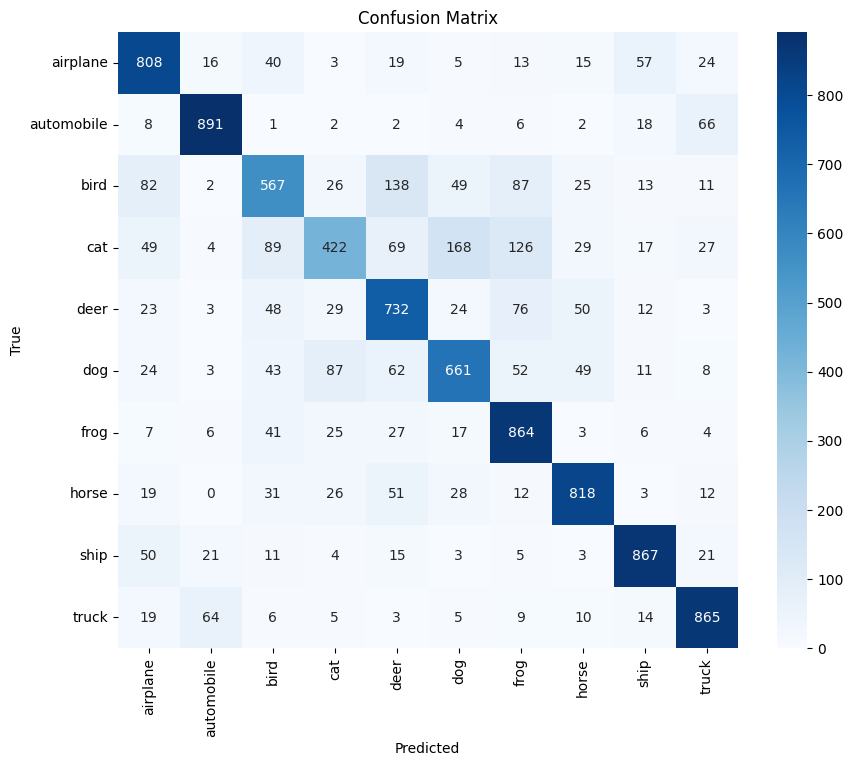

In [23]:
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=classes, columns=classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
cm_figure = plt.gcf()
plt.show()

wandb.log({"test/confusion_matrix": wandb.Image(cm_figure)})

In [24]:
wandb.finish()

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▆▆▆▆▆▇▇▇▇▇▇████
test/acc,▁
test/airplane_f1-score,▁
test/airplane_precision,▁
test/airplane_recall,▁
test/automobile_f1-score,▁
test/automobile_precision,▁
test/automobile_recall,▁
test/bird_f1-score,▁
test/bird_precision,▁
test/bird_recall,▁
